## Prerequisite Packages

In [117]:
# Based on https://www.tensorflow.org/datasets/keras_example
# use pip install <package> to find any packages that are missing
import keras         # for fitting DNNs
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from keras import backend as K
from sklearn.manifold import TSNE

## We split the data into training and testing

In [118]:
(ds_train,ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:80%]','train[80%:]','test'],  #train, validation, test
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


## Functions: normalizing images, and returning labels/images

In [119]:
#ds_test.astype(np.float32)
#image = np.expand_dims(np.expand_dims(image, axis=2), axis=0)
#image = np.concatenate((image, 0.5*image), 0)
#image = np.concatenate((image, 0.5*image), 0)
#image3D = np.expand_dims(image, axis=0)
#image3D = np.concatenate((image3D, 0.5*image3D), 0)


def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
def normalize_transpose_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.transpose(tf.cast(image, tf.float32) / 255.), label

def get_label(image,label):
    return label
def get_image(image,label):
    return image


## We apply these functions to extract model-ready data

In [120]:
# this just normalizes the image
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# cache and prefetch save memory 
ds_train = ds_train.cache()
# we shuffle data (reduces effects of order when training model)
ds_train = ds_train.shuffle(ds_info.splits['train[:80%]'].num_examples)
# batch size tells us how many samples are needed for stochastic gradient descent 
# (a small number like 32 is empirically found to be better)
ds_train = ds_train.batch(32)# batch of 32
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.shuffle(ds_info.splits['train[80%:]'].num_examples)
ds_val = ds_val.batch(32)# batch of 32  #improve the generalization of model
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)


ds_test_label=ds_test.map(
    get_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_images=ds_test.map(
    get_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

print(ds_test)
#image = ds_test.astype(np.float32)
#image = np.expand_dims(np.expand_dims(image, axis=2), axis=0)
#image = np.concatenate((image, 0.5*image), 0)
#image = np.concatenate((image, 0.5*image), 0)
#image3D = np.expand_dims(image, axis=0)
#image3D = np.concatenate((image3D, 0.5*image3D), 0)

ds_test_trans = ds_test.map(normalize_transpose_img)
ds_test_trans_images=ds_test_trans.map(get_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_trans = ds_test_trans.batch(32)
ds_test_trans = ds_test_trans.cache()
ds_test_trans = ds_test_trans.prefetch(tf.data.experimental.AUTOTUNE)


ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


## Model training

In [121]:

# this example model 
#    - first flattens data into a vector (image is 28 x 28)
#    - then creates a dense 128-node layer
#    - then creates a dropout "layer" (it says how many nodes are dropped out in previous layer)
#    - then another 128-node layer
#    - and finally 10-node layer as the head. 
# The max value of the head = the predicted image
#



dense=False
if dense:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(56,activation='relu'),
    tf.keras.layers.Dropout(.2, input_shape=(56,)),
      tf.keras.layers.Dense(24,activation='relu'),
      tf.keras.layers.Dense(10)
    ])
else:
    model = tf.keras.models.Sequential([])
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1))) #kernal size: how wide it is
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(.5))   #>>>doesn't overfit, better generalize
    #model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
    model.add(tf.keras.layers.Flatten())
    #model.add(tf.keras.layers.BatchNormalization())
    #tf.keras.layers.Dense(24,activation='relu'),
    model.add(tf.keras.layers.Dense(10)) #0-9
# this specifies how we find the best NN
# - Optimizer like Adam is found to work well
# - Loss is "sparse categorical cross entropy" (you can choose whatever loss function on keras improves your model)
# - We also record accuracy ("metric"), this does not affect training
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# this is stuff we record
# "early stopping" tells us when we found the optimum without training more epochs
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# the training of the model
# we use ds_train data, and up to 30 epochs (less when Early Stopping is used)
# we also record callbacks, and we determine the optimal model by where validation is smallest
history=model.fit(
    ds_train,
    epochs=30,
    callbacks=my_callbacks,
    validation_data=ds_val
)


Epoch 1/30
1500/1500 [==============================] - 126s 83ms/step - loss: 0.3060 - sparse_categorical_accuracy: 0.9061 - val_loss: 0.0685 - val_sparse_categorical_accuracy: 0.9805
Epoch 2/30
1500/1500 [==============================] - 143s 96ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0533 - val_sparse_categorical_accuracy: 0.9835
Epoch 3/30
1500/1500 [==============================] - 144s 96ms/step - loss: 0.0491 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.0464 - val_sparse_categorical_accuracy: 0.9861
Epoch 4/30
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0383 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.0474 - val_sparse_categorical_accuracy: 0.9860


## Here we check the accuracy in the held-out test dataset

In [122]:

gt_labels=list(ds_test_label)
predictions=[np.argmax(im) for im in model.predict(ds_test)]
print(accuracy_score(predictions,gt_labels))



0.9881


## How does loss in training/validation vary with epoch?

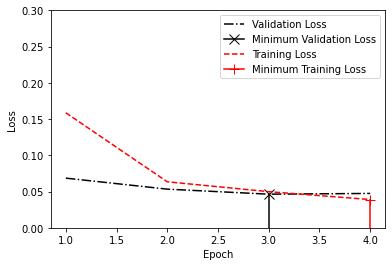

In [123]:
# These definitions make the plot code easier to read
minvalx=np.argmin(history.history['val_loss'])+1
minvaly=min(history.history['val_loss'])
mintrainx=np.argmin(history.history['loss'])+1
mintrainy=min(history.history['loss'])
lowpoint_val=np.array([[minvalx,-10],[minvalx,minvaly]])
lowpoint_train=np.array([[mintrainx,-10],[mintrainx,mintrainy]])

# N.B., it's always good to label axes and lines
plt.plot(list(range(1,len(history.history['val_loss'])+1)),history.history['val_loss'],'k-.',label='Validation Loss')
plt.plot(lowpoint_val[:,0],lowpoint_val[:,1],'kx-',markersize=10,label='Minimum Validation Loss')
plt.plot(list(range(1,len(history.history['loss'])+1)),history.history['loss'],'r--',label='Training Loss')
plt.plot(lowpoint_train[:,0],lowpoint_train[:,1],'r+-',markersize=10,label='Minimum Training Loss')
# creates legend from "label" attribute
plt.legend()
# y limit
plt.ylim([0,0.3])
# axes labels
plt.ylabel('Loss')
plt.xlabel('Epoch')
# show the plot
# to save figure, you can use plt.savefig(<file name>)
plt.show()

#black spot: Best model 

# Adversarial examples

Confidence: 0.8931551


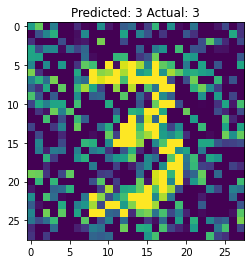

Confidence: 0.98730445


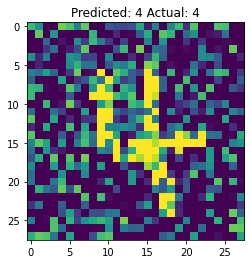

Confidence: 0.94032794


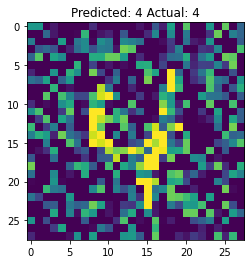

Confidence: 0.82161236


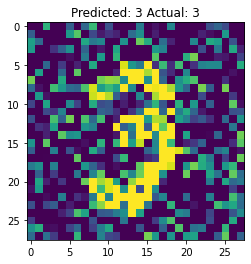

Confidence: 0.8980649


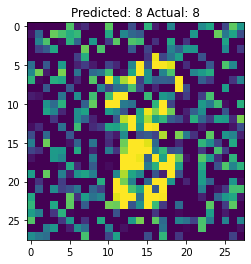

Confidence: 0.84811866


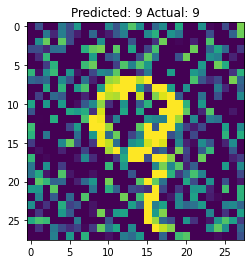

Confidence: 0.38847274


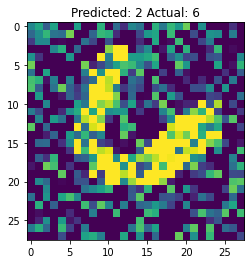

Confidence: 0.4866008


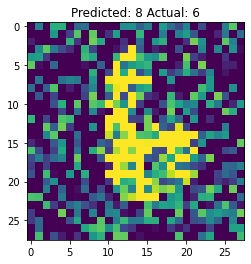

Confidence: 0.4545828


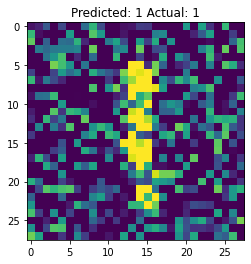

Confidence: 0.57489824


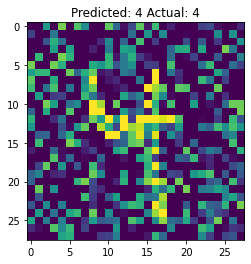

Confidence: 0.7313181


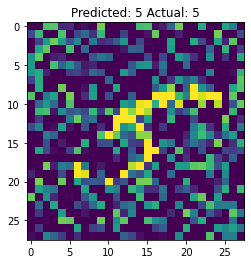

Confidence: 0.9270561


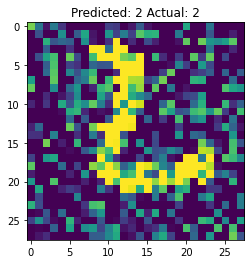

Confidence: 0.6706131


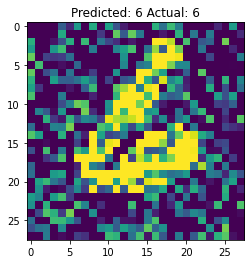

Confidence: 0.6434516


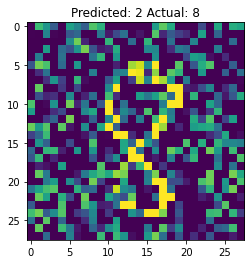

Confidence: 0.9556591


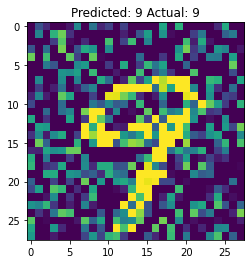

Confidence: 0.7745723


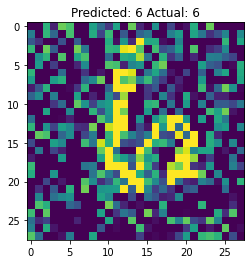

Confidence: 0.26745817


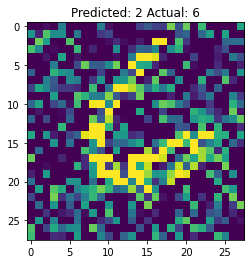

Confidence: 0.45050722


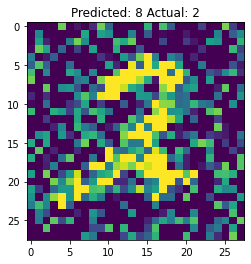

Confidence: 0.8964382


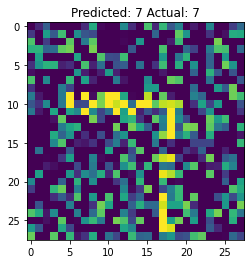

Confidence: 0.5368114


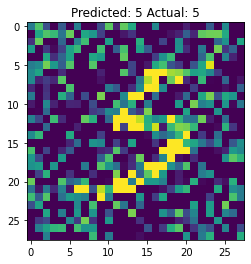

Confidence: 0.8742512


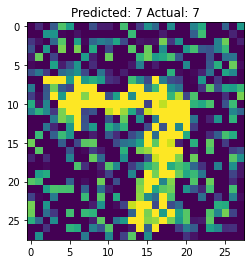

Confidence: 0.8621452


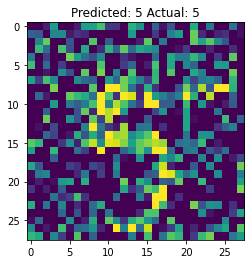

Confidence: 0.92235744


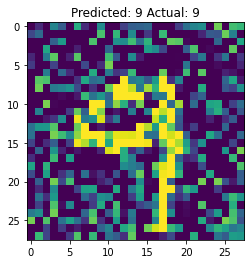

Confidence: 0.50116587


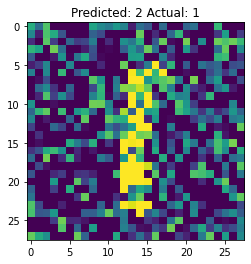

Confidence: 0.631281


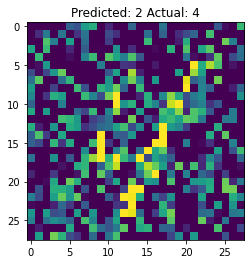

Confidence: 0.845186


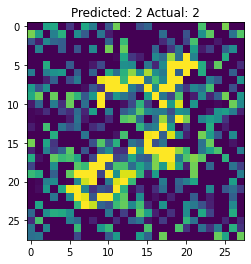

Confidence: 0.48716938


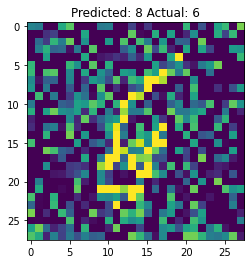

Confidence: 0.9463119


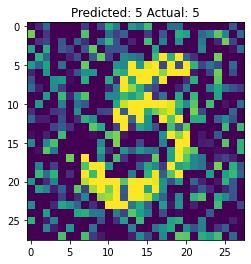

Confidence: 0.5664787


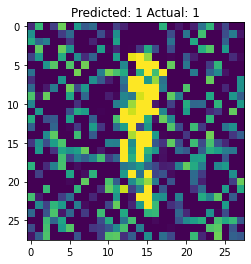

Confidence: 0.5722028


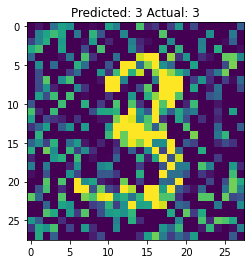

Confidence: 0.6292736


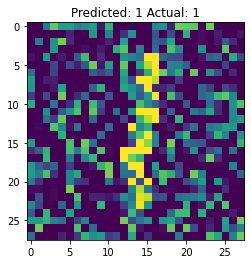

Confidence: 0.9989668


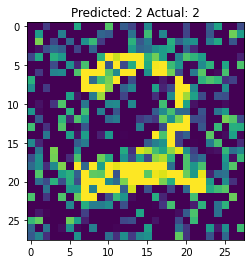

Confidence: 0.95427


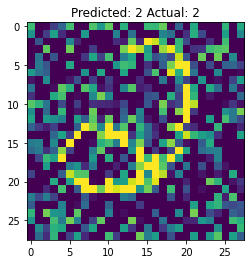

Confidence: 0.5233902


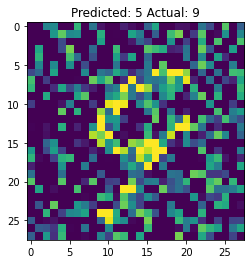

Confidence: 0.27329636


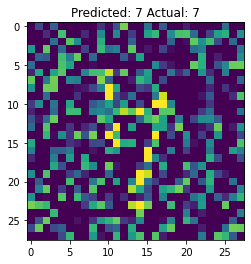

Confidence: 0.99811035


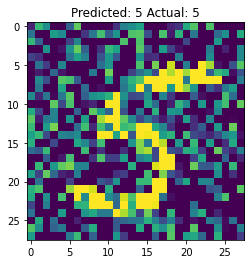

Confidence: 0.7933312


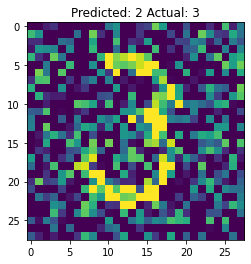

Confidence: 0.8948632


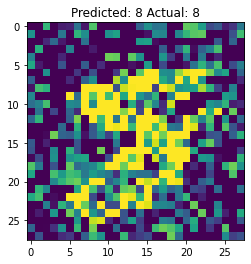

Confidence: 0.89437723


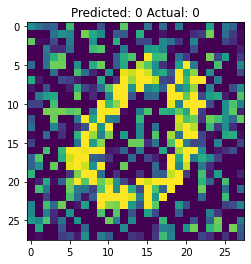

Confidence: 0.50341123


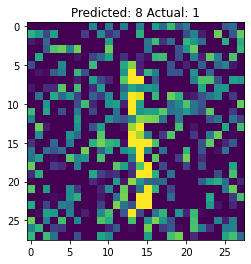

Confidence: 0.6978002


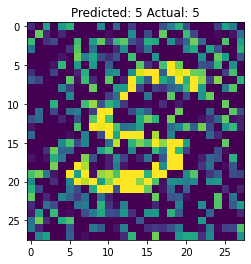

Confidence: 0.75547004


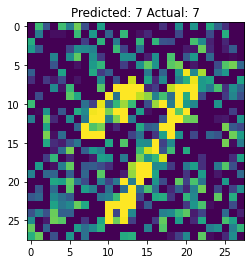

Confidence: 0.9717254


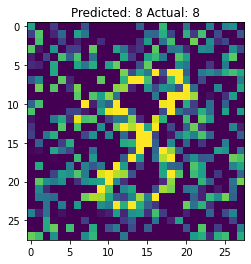

Confidence: 0.6407728


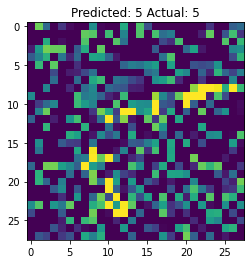

Confidence: 0.36078918


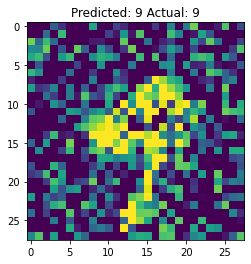

Confidence: 0.9756632


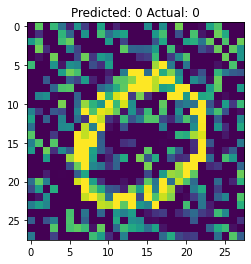

Confidence: 0.8308833


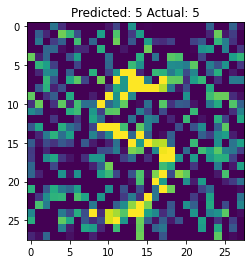

Confidence: 0.2802906


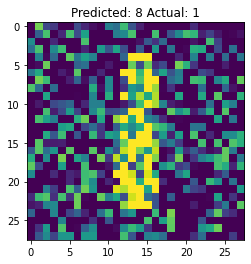

Confidence: 0.28589723


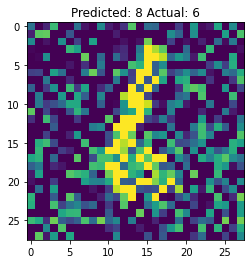

Confidence: 0.476719


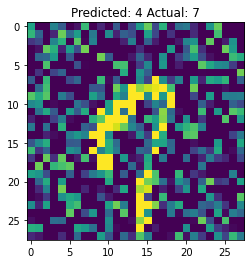

Confidence: 0.97365373


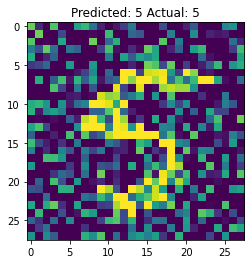

Confidence: 0.8421298


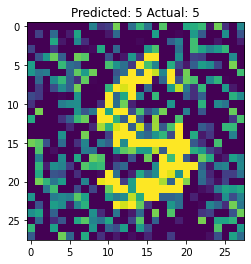

Confidence: 0.9717731


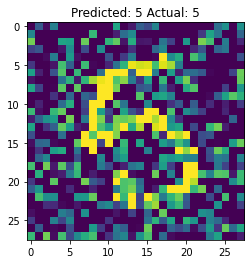

Confidence: 0.9629965


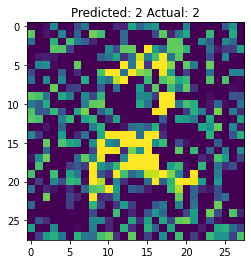

Confidence: 0.72831094


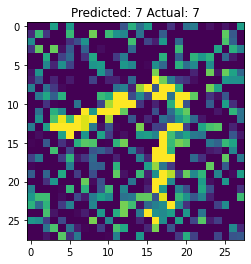

Confidence: 0.75611323


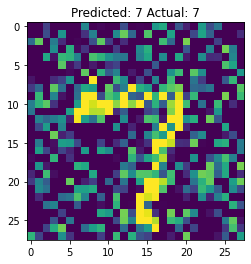

Confidence: 0.5180108


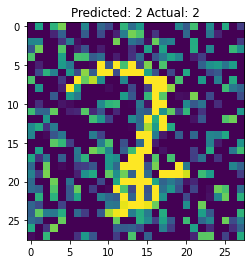

Confidence: 0.4302563


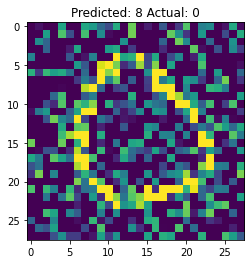

Confidence: 0.52472264


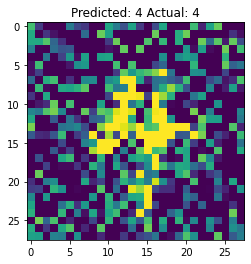

Confidence: 0.940925


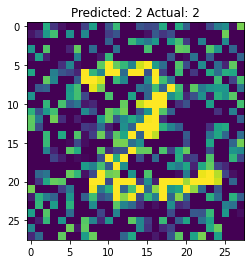

Confidence: 0.62428486


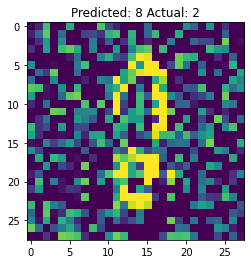

Confidence: 0.8688306


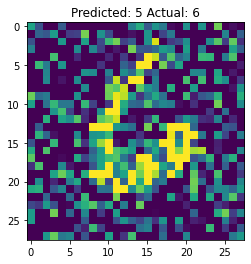

Confidence: 0.9952344


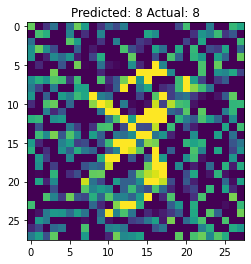

Confidence: 0.48191953


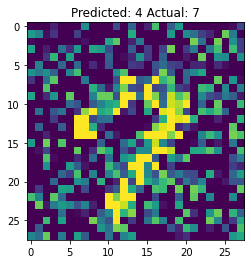

Confidence: 0.72963434


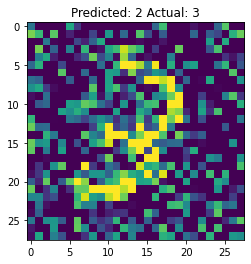

Confidence: 0.93858004


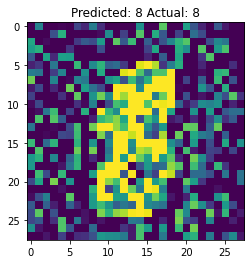

Confidence: 0.9929011


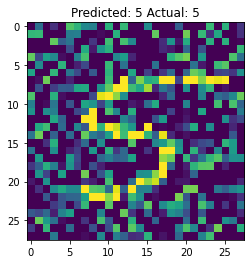

Confidence: 0.44965485


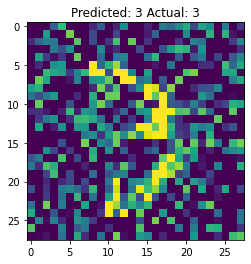

Confidence: 0.9779595


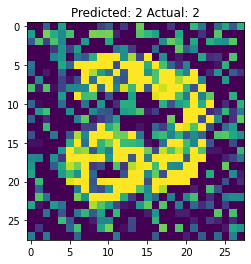

Confidence: 0.65398276


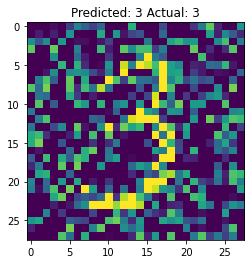

Confidence: 0.45950565


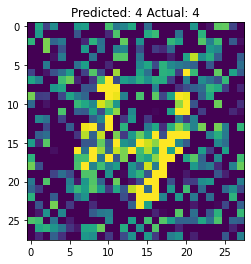

Confidence: 0.5776436


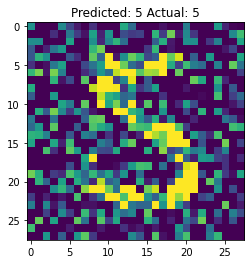

Confidence: 0.9879074


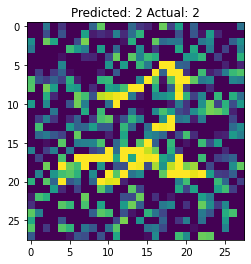

Confidence: 0.4632817


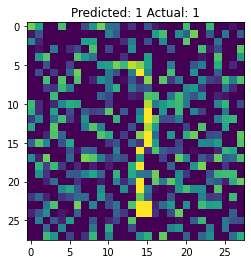

Confidence: 0.55444145


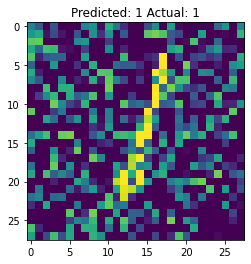

Confidence: 0.89396465


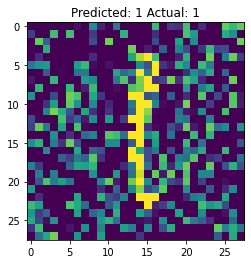

Confidence: 0.94960713


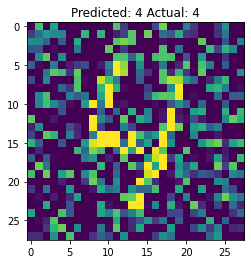

Confidence: 0.28956982


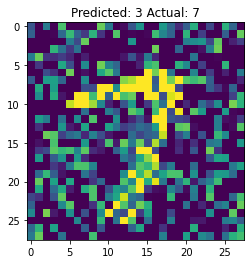

Confidence: 0.67277765


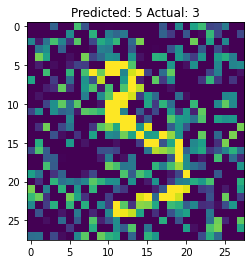

Confidence: 0.8576544


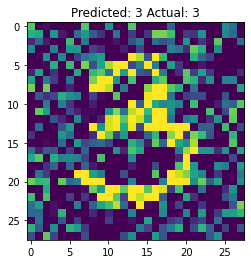

Confidence: 0.49011254


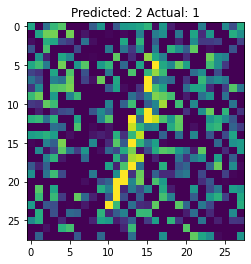

Confidence: 0.44193438


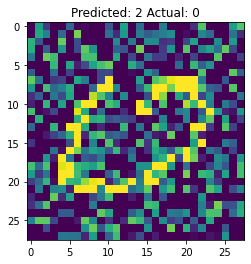

Confidence: 0.6668544


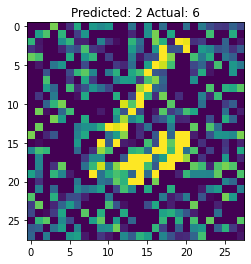

Confidence: 0.7548667


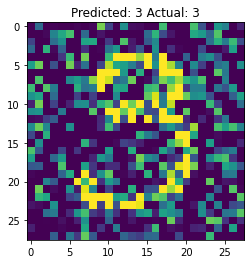

Confidence: 0.9351669


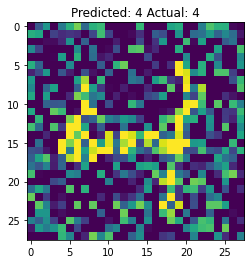

Confidence: 0.48243323


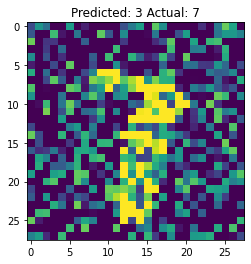

Confidence: 0.6375088


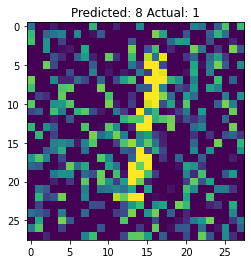

Confidence: 0.8647087


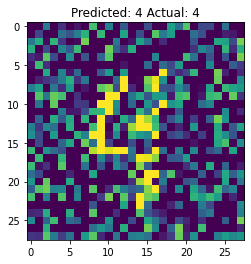

Confidence: 0.8074142


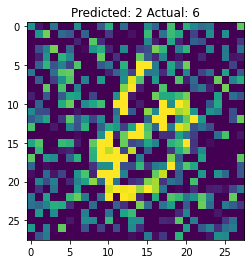

Confidence: 0.7471767


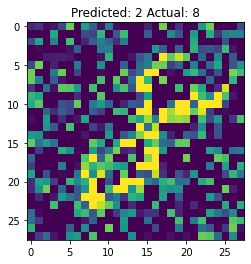

Confidence: 0.988128


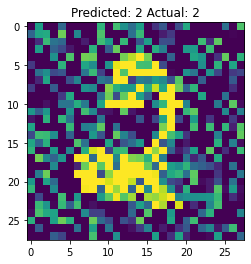

Confidence: 0.67108005


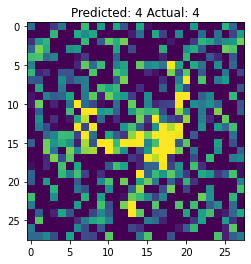

Confidence: 0.51405084


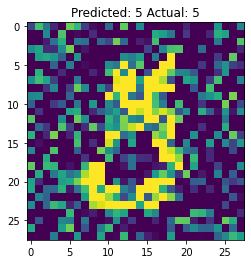

Confidence: 0.75751925


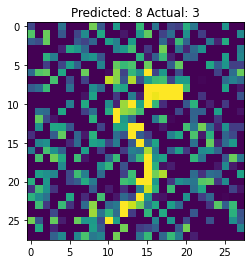

Confidence: 0.5661549


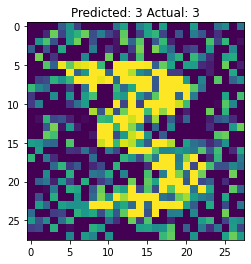

Confidence: 0.9378875


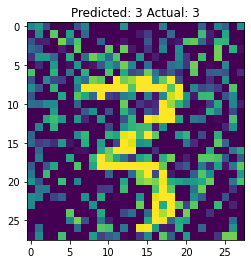

Confidence: 0.56071585


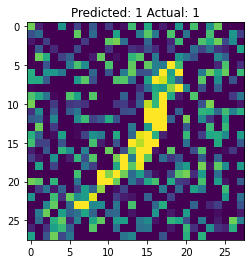

Confidence: 0.33625057


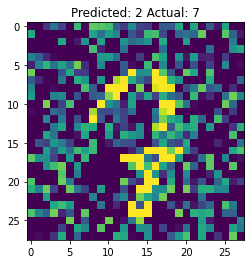

Confidence: 0.99784654


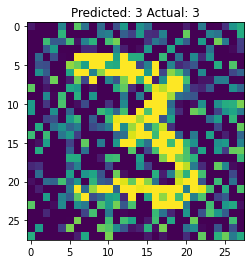

Confidence: 0.99184805


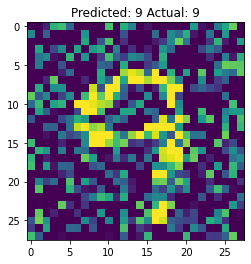

Confidence: 0.81929487


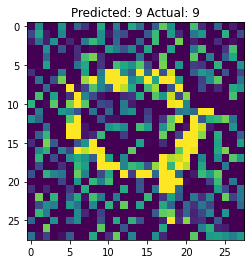

Confidence: 0.96981716


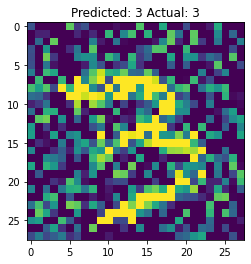

Confidence: 0.7311473


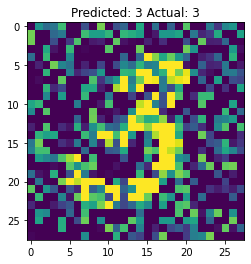

Confidence: 0.67286754


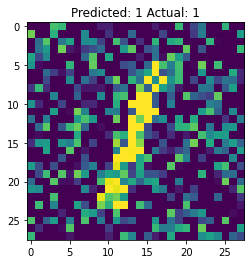

Confidence: 0.9140698


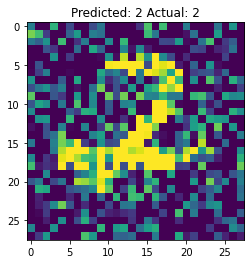

Confidence: 0.7681021


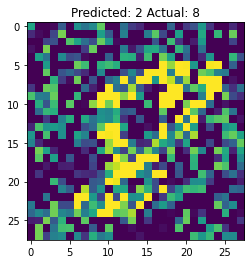

Confidence: 0.78827786


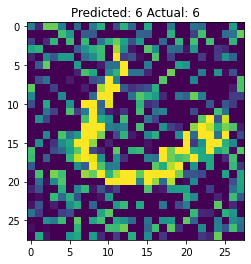

Confidence: 0.6784123


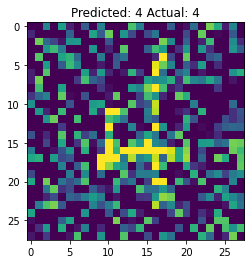

Confidence: 0.9932358


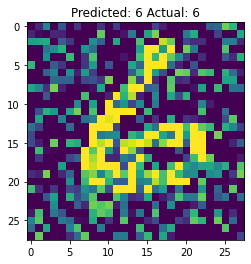

Confidence: 0.5731845


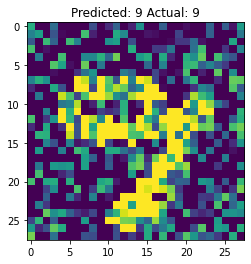

Confidence: 0.33713737


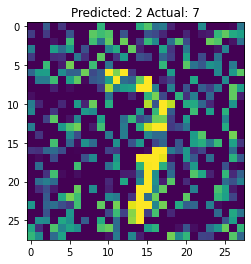

Confidence: 0.8690543


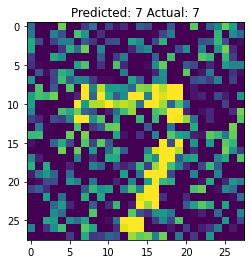

Confidence: 0.4005016


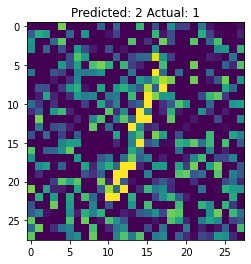

Confidence: 0.600345


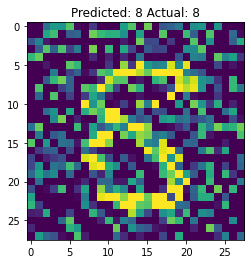

Confidence: 0.84389967


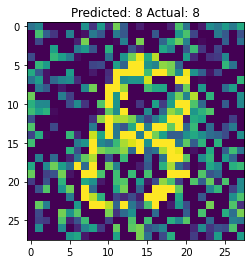

Confidence: 0.95866394


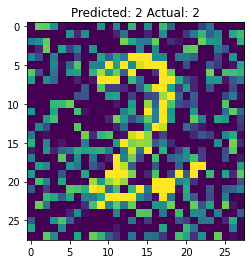

Confidence: 0.5151235


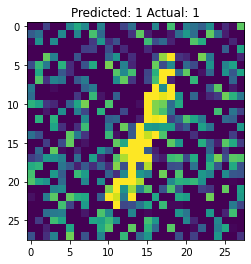

Confidence: 0.80041605


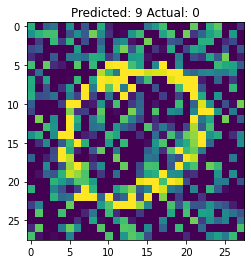

Confidence: 0.5064306


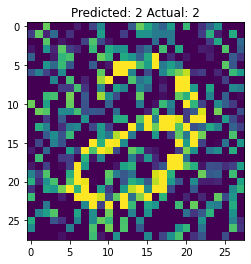

Confidence: 0.82327586


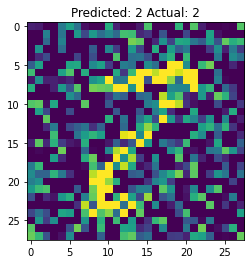

Confidence: 0.36315054


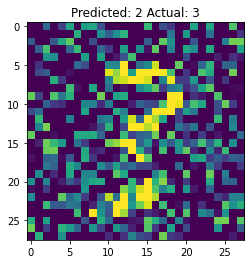

Confidence: 0.5964942


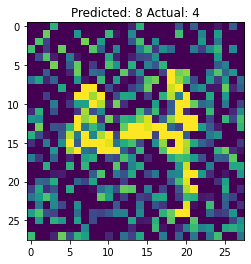

Confidence: 0.9061633


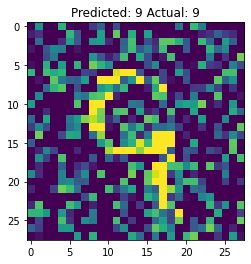

Confidence: 0.7025622


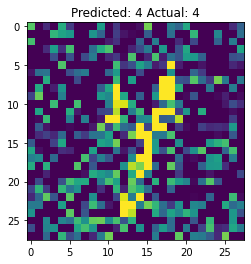

Confidence: 0.9810552


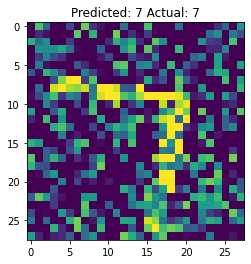

Confidence: 0.96819896


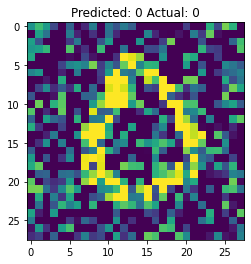

Confidence: 0.5385294


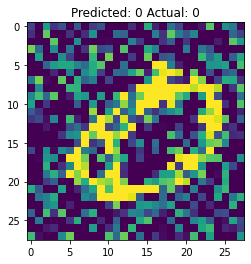

Confidence: 0.5129868


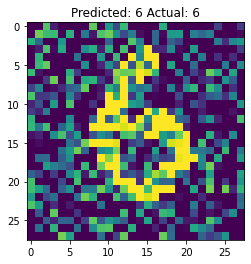

Confidence: 0.44314682


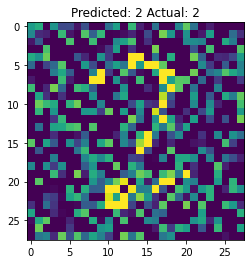

Confidence: 0.8847059


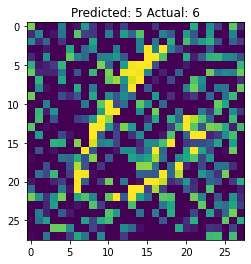

Confidence: 0.9652348


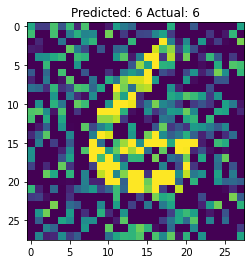

Confidence: 0.6292625


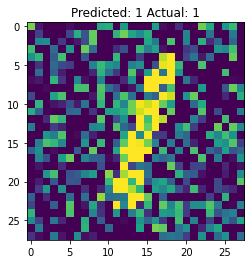

Confidence: 0.5810054


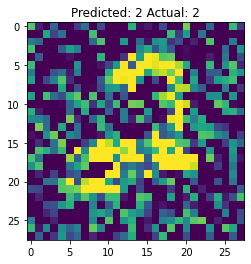

Confidence: 0.5178917


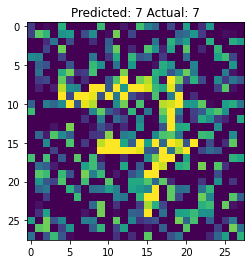

Confidence: 0.6720982


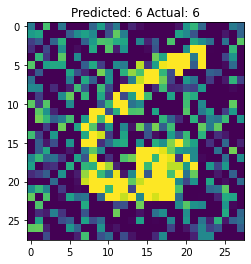

Confidence: 0.763733


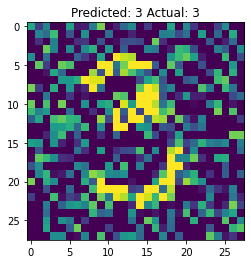

Confidence: 0.66943055


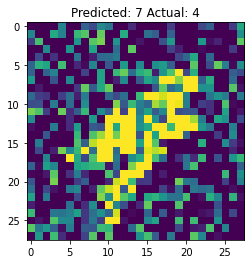

Confidence: 0.98526686


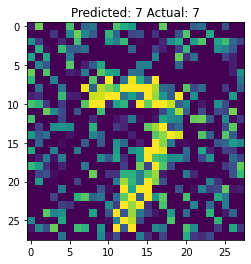

Confidence: 0.42798725


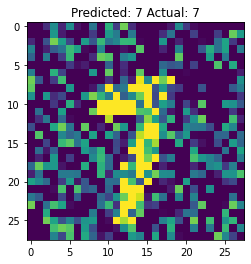

Confidence: 0.3286065


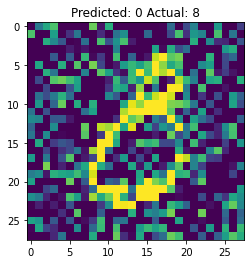

Confidence: 0.58849984


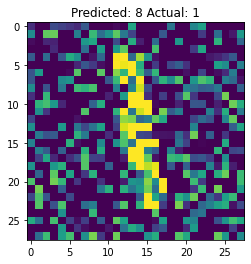

Confidence: 0.8887803


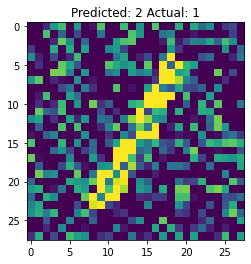

Confidence: 0.72890586


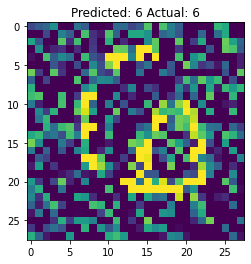

Confidence: 0.98836976


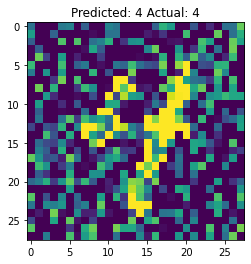

Confidence: 0.5179792


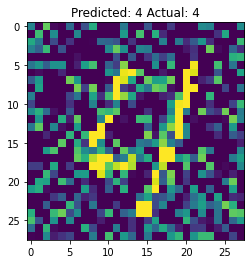

Confidence: 0.8479519


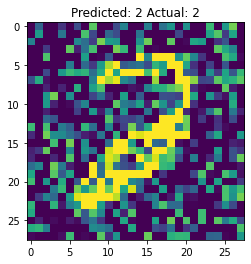

Confidence: 0.843091


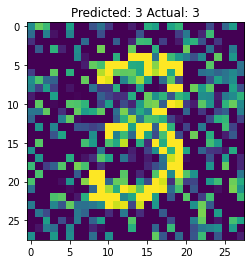

Confidence: 0.9954663


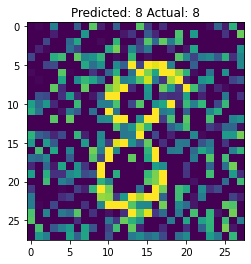

Confidence: 0.55800235


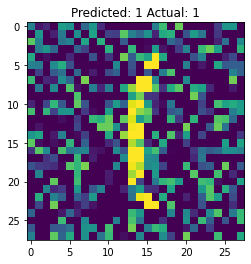

Confidence: 0.7665515


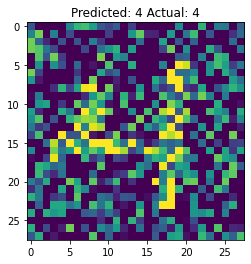

Confidence: 0.43229586


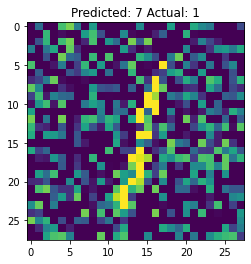

Confidence: 0.486038


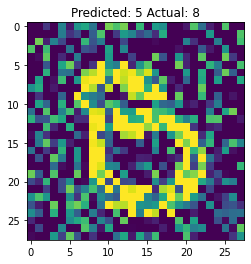

Confidence: 0.76619923


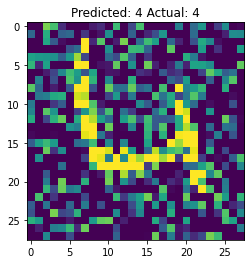

Confidence: 0.9139788


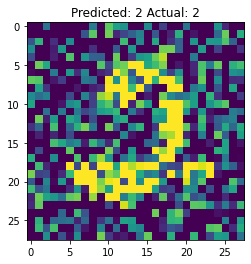

Confidence: 0.9323165


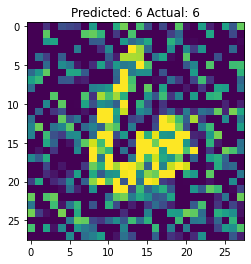

Confidence: 0.5865833


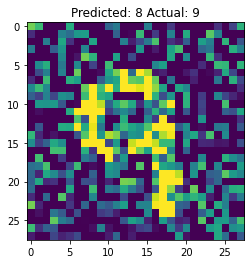

Confidence: 0.87503093


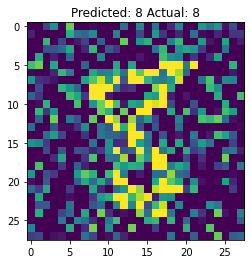

Confidence: 0.9683807


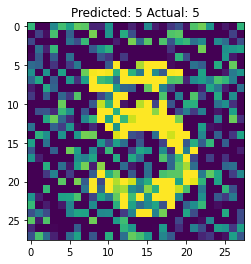

Confidence: 0.47675866


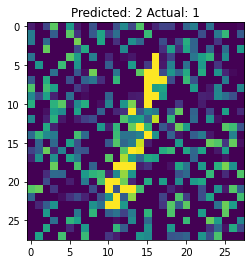

Confidence: 0.58530354


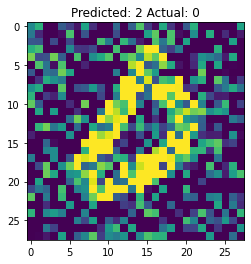

Confidence: 0.9688117


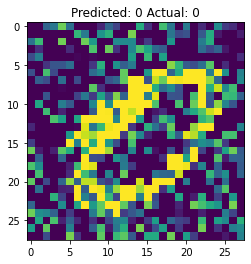

Confidence: 0.91278756


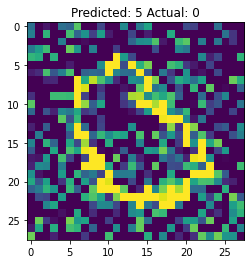

Confidence: 0.9744057


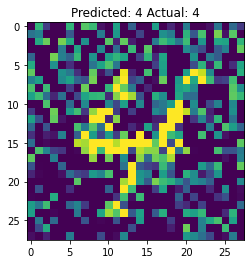

Confidence: 0.4734723


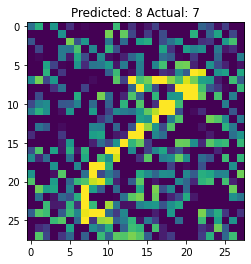

Confidence: 0.5263301


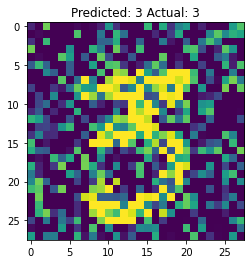

Confidence: 0.98637116


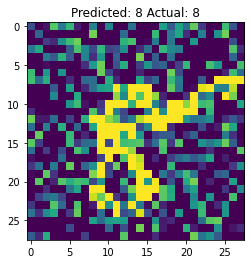

Confidence: 0.8891077


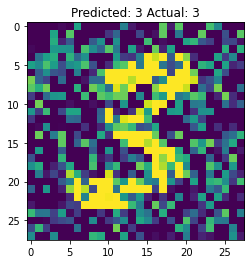

Confidence: 0.87603986


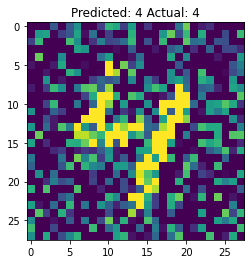

Confidence: 0.80013496


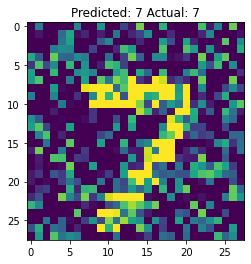

Confidence: 0.8266279


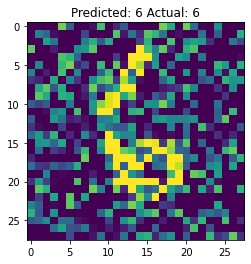

Confidence: 0.96037257


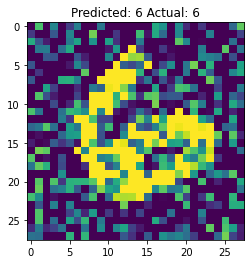

Confidence: 0.66687834


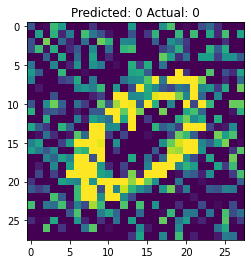

Confidence: 0.79763716


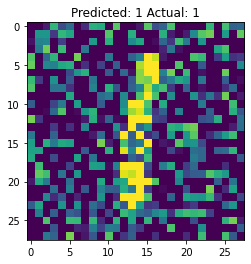

Confidence: 0.89556104


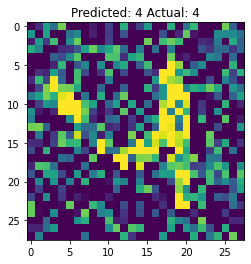

Confidence: 0.9486637


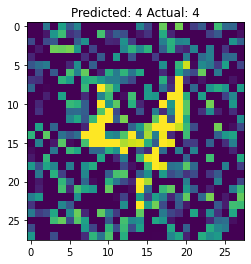

Confidence: 0.92485845


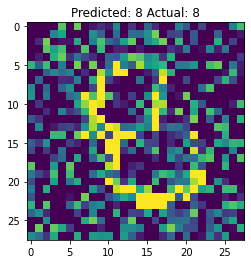

Confidence: 0.9268257


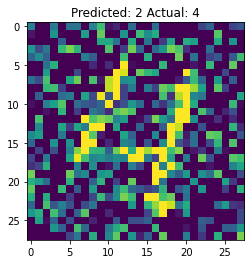

Confidence: 0.9980471


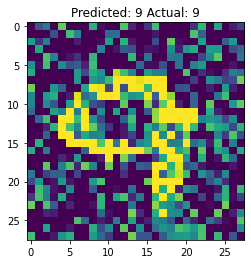

Confidence: 0.45069382


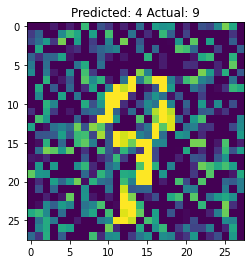

Confidence: 0.57925045


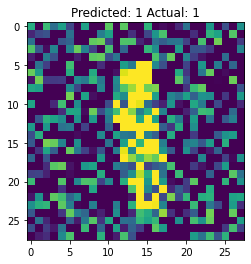

Confidence: 0.69979393


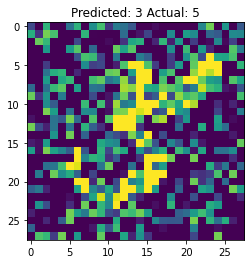

Confidence: 0.95706433


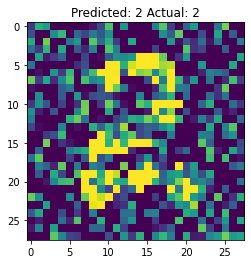

Confidence: 0.5842018


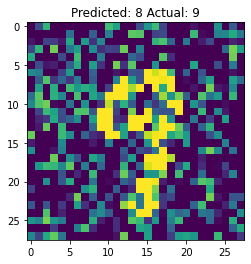

Confidence: 0.9517037


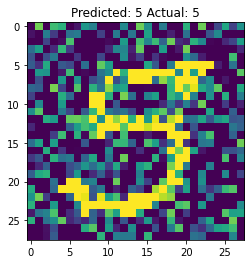

Confidence: 0.9742182


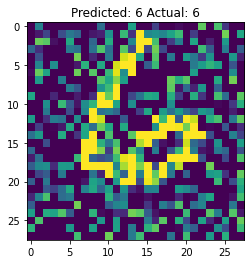

Confidence: 0.8242537


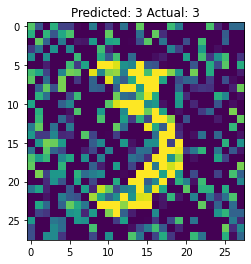

Confidence: 0.7969559


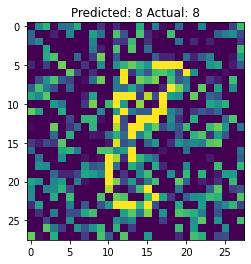

Confidence: 0.7861797


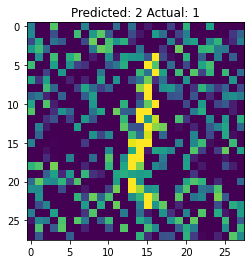

Confidence: 0.80974245


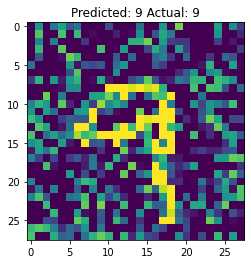

Confidence: 0.6486148


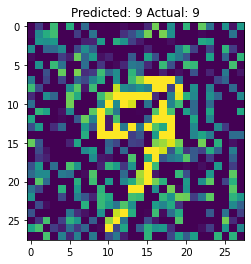

Confidence: 0.9579205


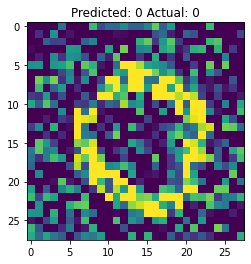

Confidence: 0.9475633


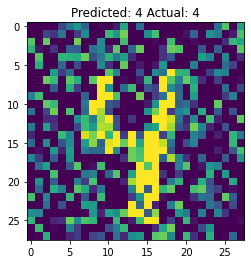

Confidence: 0.999871


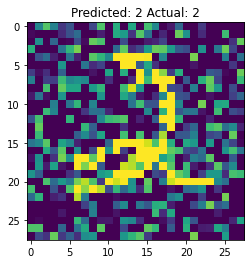

Confidence: 0.9855615


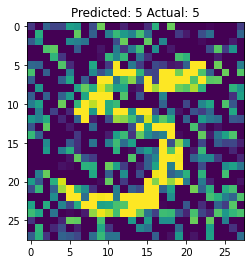

Confidence: 0.91064614


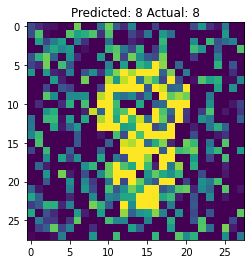

Confidence: 0.9755479


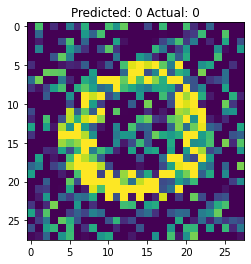

Confidence: 0.8017196


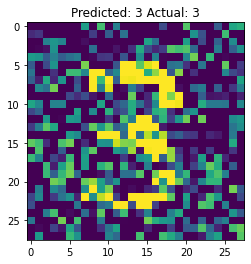

Confidence: 0.46873975


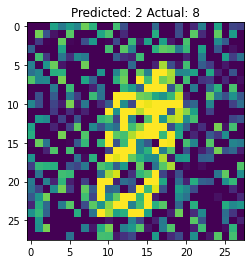

Confidence: 0.5214196


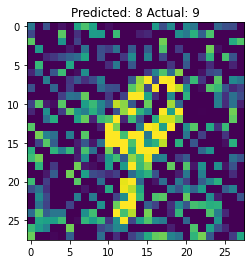

Confidence: 0.8869952


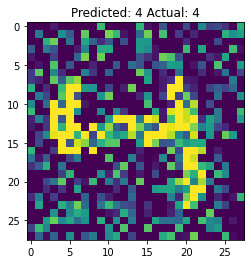

Confidence: 0.9245055


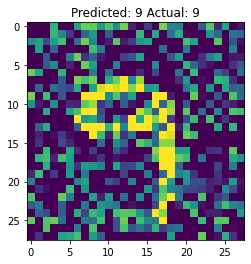

Confidence: 0.9121051


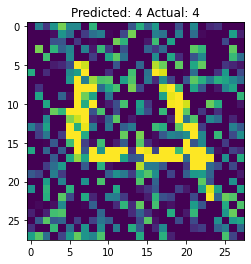

Confidence: 0.84303206


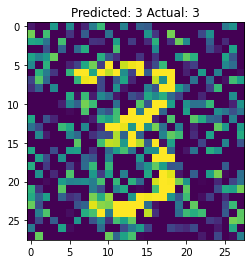

Confidence: 0.603704


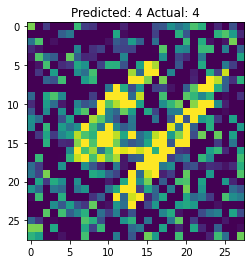

Confidence: 0.5287411


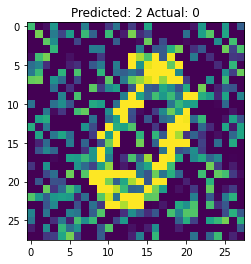

Confidence: 0.99251574


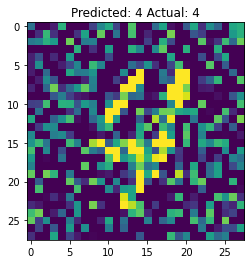

Confidence: 0.8814953


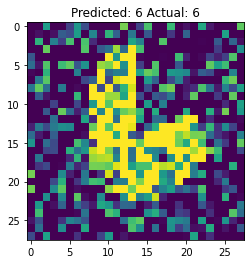

Confidence: 0.99852514


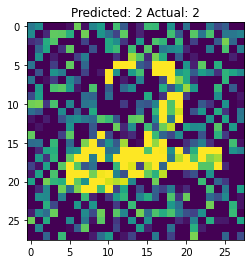

Confidence: 0.46679187


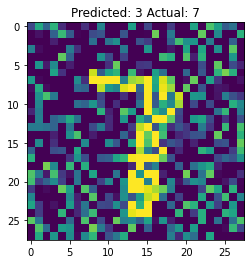

Confidence: 0.46641207


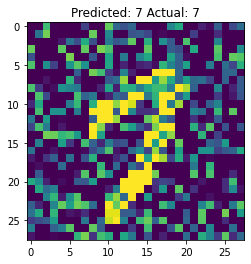

Confidence: 0.5799884


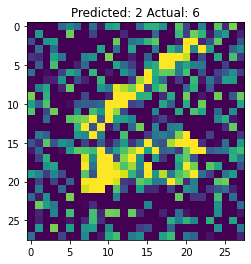

Confidence: 0.5675996


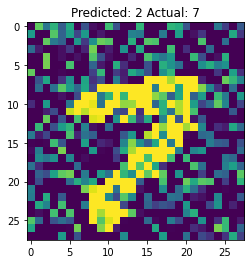

Confidence: 0.51204


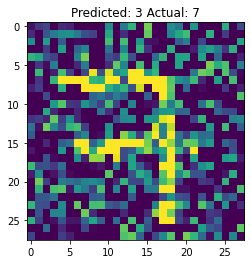

Confidence: 0.9716532


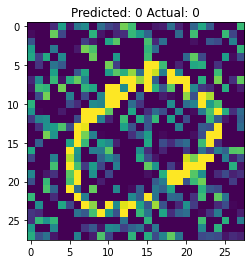

Confidence: 0.78490156


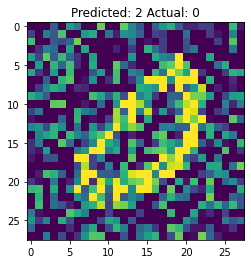

Confidence: 0.9421326


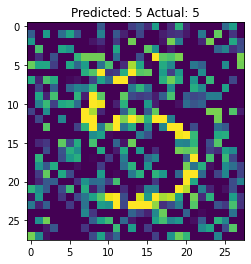

Confidence: 0.5306584


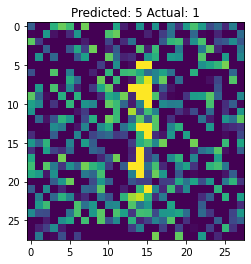

Confidence: 0.7176961


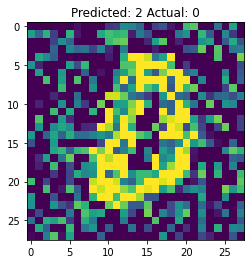

Confidence: 0.82051665


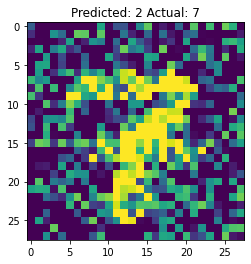

Confidence: 0.63614553


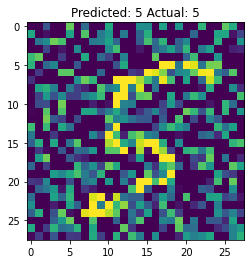

Confidence: 0.46112806


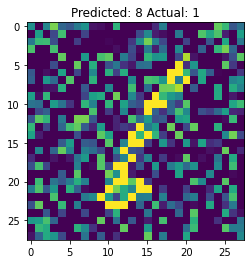

Confidence: 0.82909554


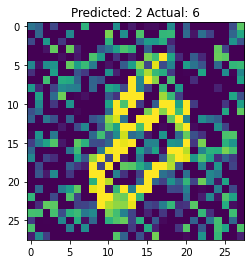

Confidence: 0.7847129


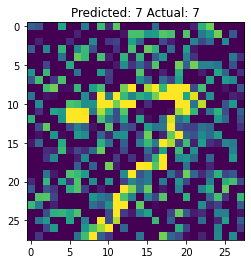

Confidence: 0.8713789


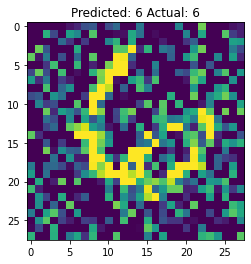

Confidence: 0.595923


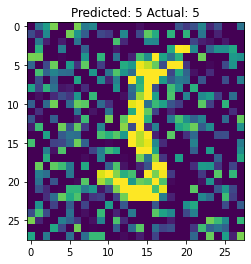

Confidence: 0.963374


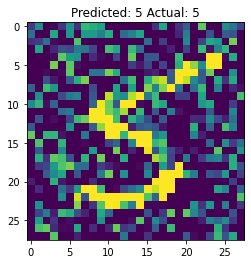

Confidence: 0.96449697


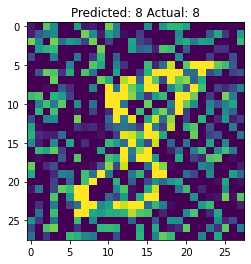

Confidence: 0.40644625


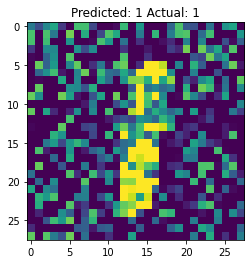

Confidence: 0.9899323


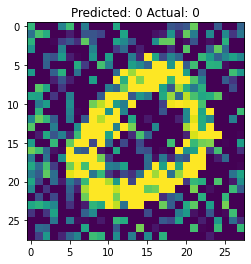

Confidence: 0.5178987


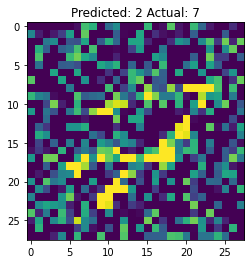

Confidence: 0.89057165


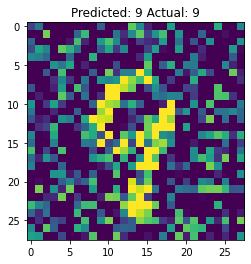

Confidence: 0.897874


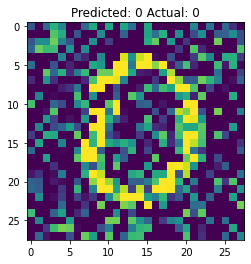

Confidence: 0.7294597


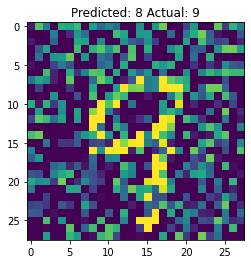

Confidence: 0.9801001


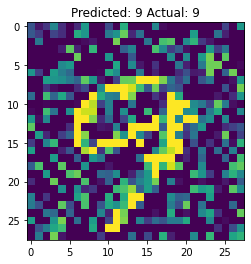

Confidence: 0.5163793


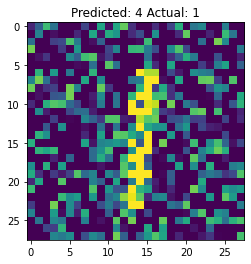

Confidence: 0.99909943


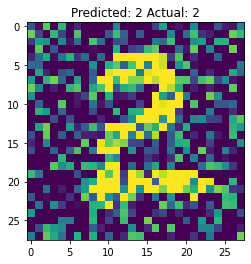

Confidence: 0.5095954


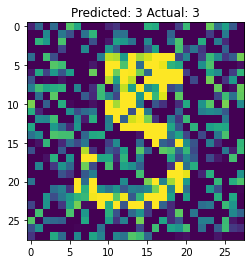

Confidence: 0.32981324


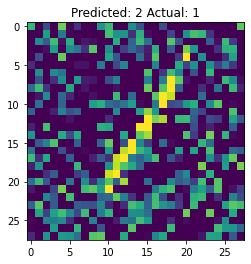

Confidence: 0.6215505


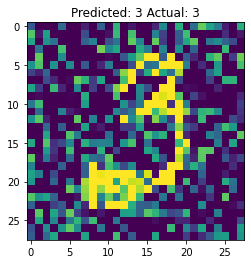

Confidence: 0.8071143


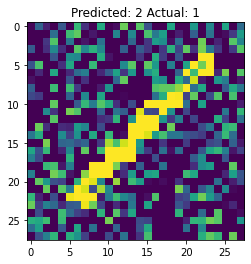

Confidence: 0.32935962


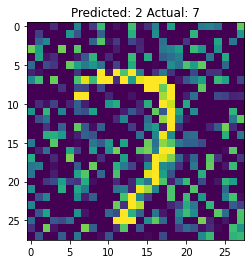

Confidence: 0.59507334


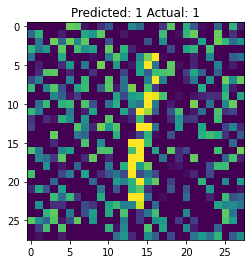

Confidence: 0.54829836


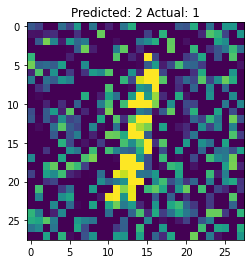

Confidence: 0.83779895


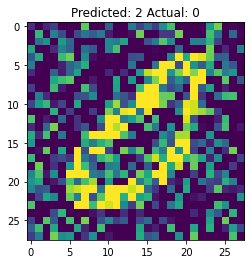

Confidence: 0.785307


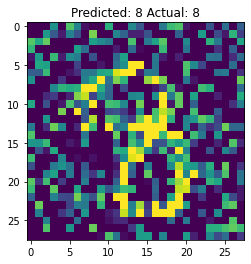

Confidence: 0.65803015


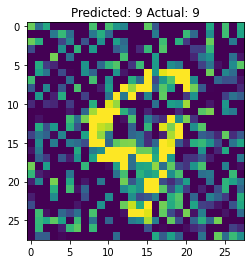

Confidence: 0.9079482


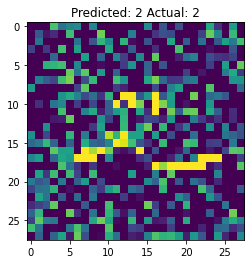

Confidence: 0.83489954


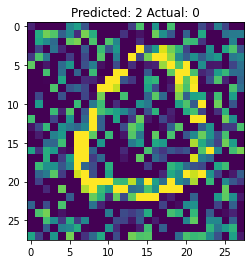

Confidence: 0.76057255


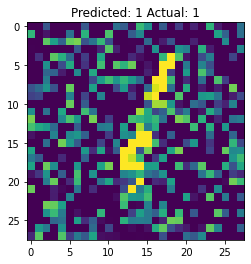

Confidence: 0.9493712


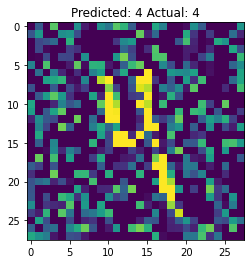

Confidence: 0.5523583


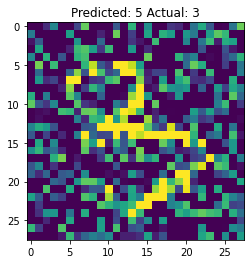

Confidence: 0.9411074


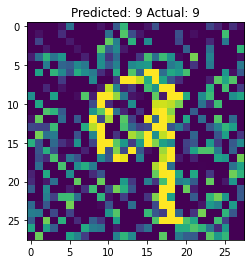

Confidence: 0.8186154


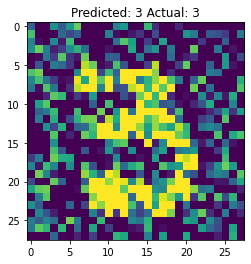

Confidence: 0.725951


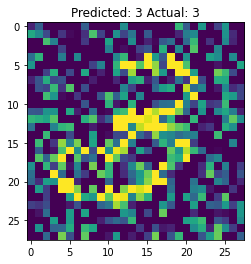

Confidence: 0.49905938


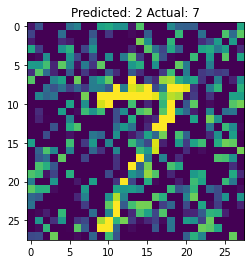

Confidence: 0.9966496


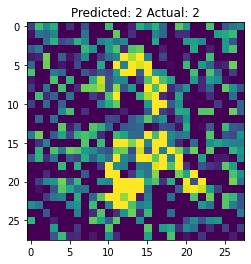

Confidence: 0.6123393


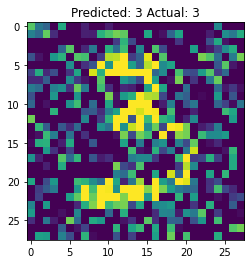

Confidence: 0.49242663


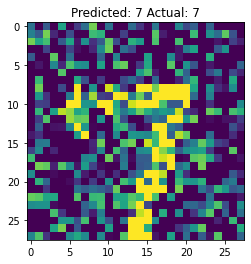

Confidence: 0.8962468


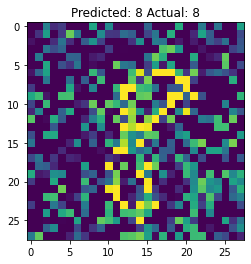

Confidence: 0.84907645


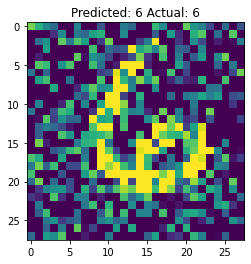

Confidence: 0.419909


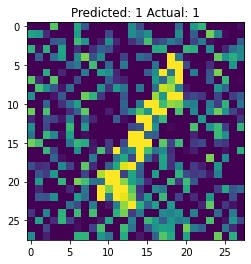

Confidence: 0.9787491


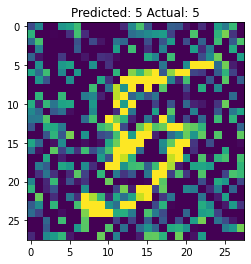

Confidence: 0.78235894


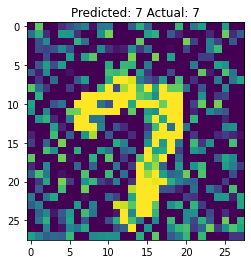

Confidence: 0.7747565


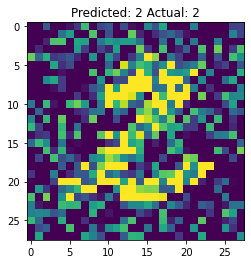

Confidence: 0.8553874


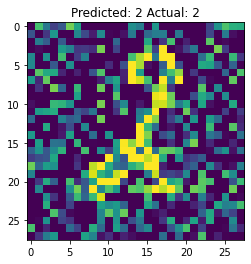

Confidence: 0.91312766


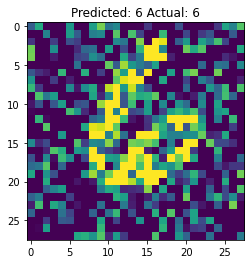

Confidence: 0.9403837


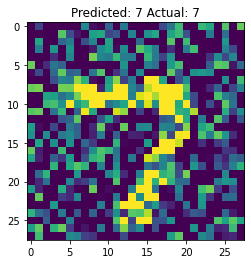

Confidence: 0.90731007


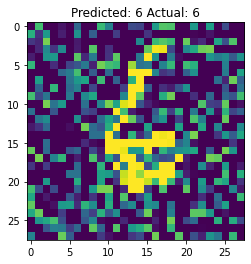

Confidence: 0.7717827


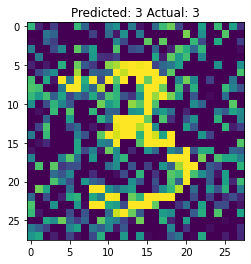

Confidence: 0.68210614


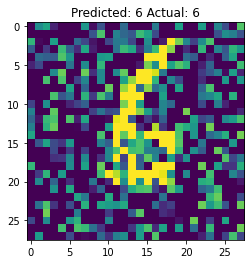

Confidence: 0.98340994


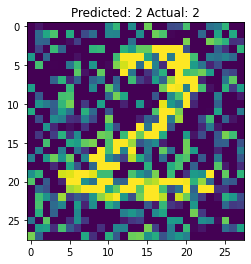

Confidence: 0.72253436


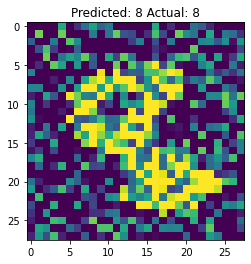

Confidence: 0.841913


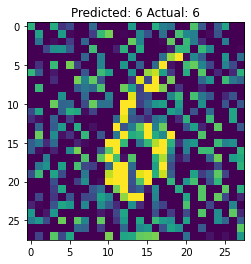

Confidence: 0.93662244


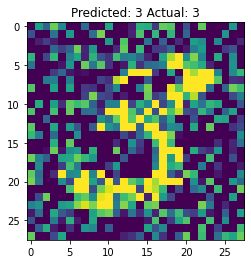

Confidence: 0.39818212


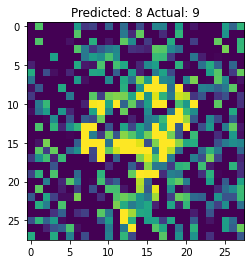

Confidence: 0.9998388


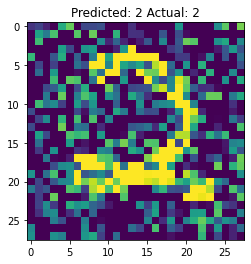

Confidence: 0.465712


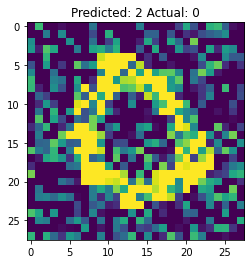

Confidence: 0.60658896


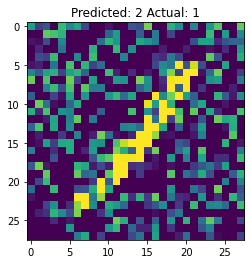

Confidence: 0.41635615


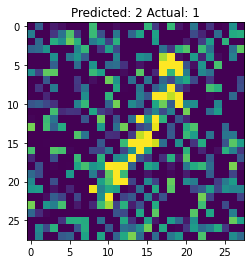

Confidence: 0.71163553


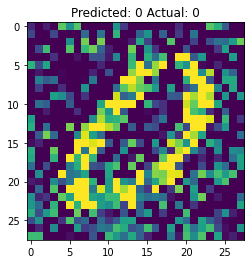

Confidence: 0.89769286


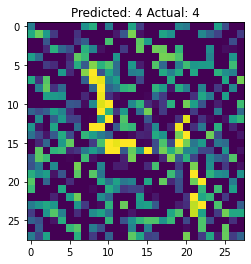

Confidence: 0.34635738


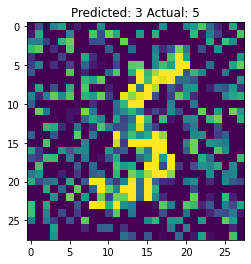

Confidence: 0.99251574


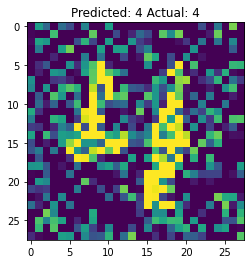

Confidence: 0.6377323


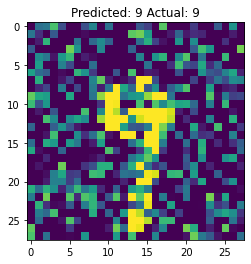

Confidence: 0.98135895


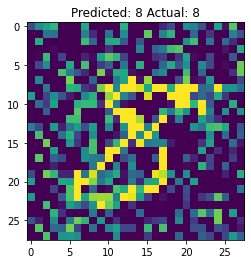

Confidence: 0.9584346


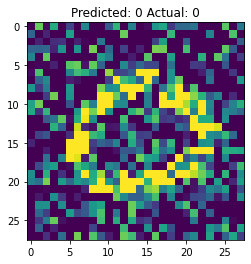

Confidence: 0.5949166


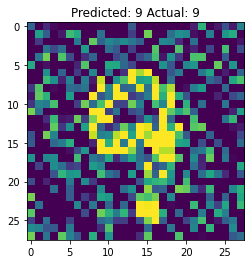

Confidence: 0.43935728


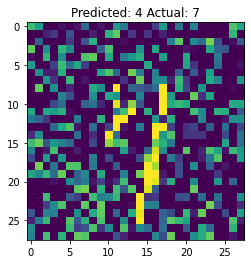

Confidence: 0.8046494


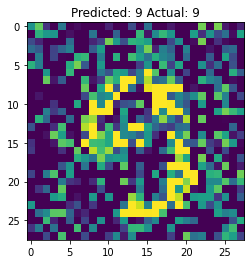

Confidence: 0.68646944


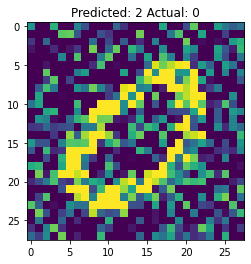

Confidence: 0.77753896


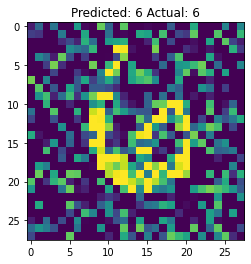

Confidence: 0.9786207


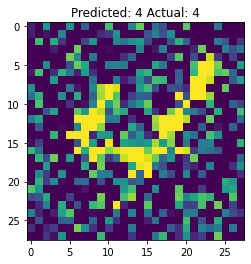

Confidence: 0.9371733


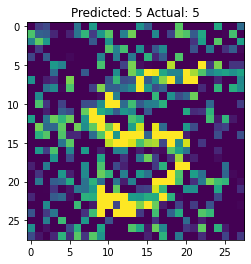

Confidence: 0.5702011


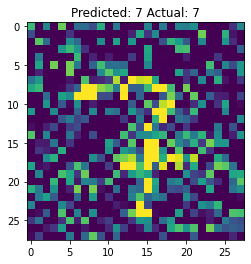

Confidence: 0.8963549


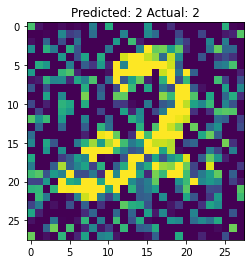

Confidence: 0.4523743


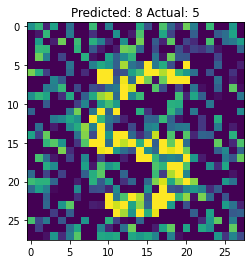

Confidence: 0.35001945


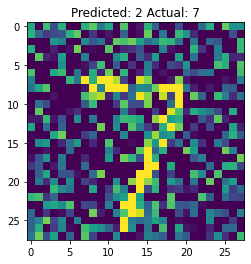

Confidence: 0.6241915


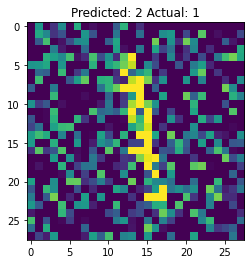

Confidence: 0.38104627


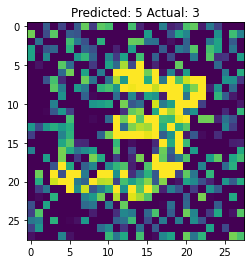

Confidence: 0.6032183


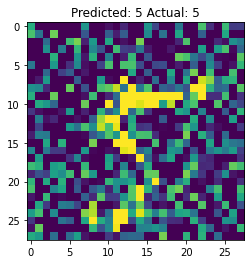

Confidence: 0.50438994


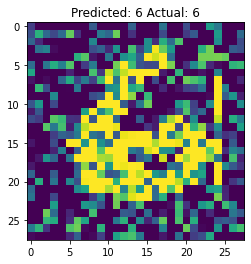

Confidence: 0.95765114


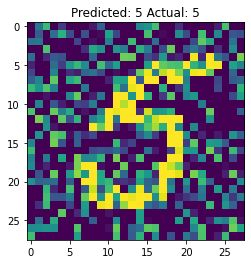

Confidence: 0.9560766


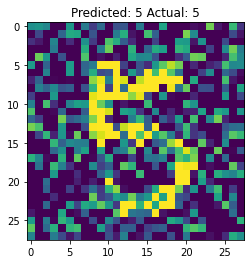

Confidence: 0.771176


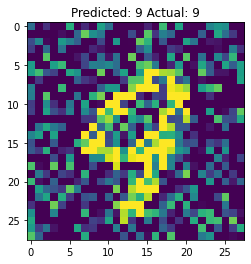

Confidence: 0.56331116


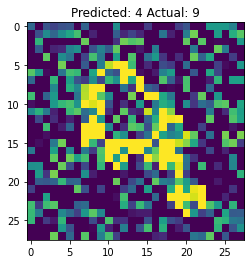

Confidence: 0.534873


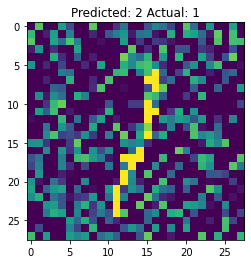

Confidence: 0.56831175


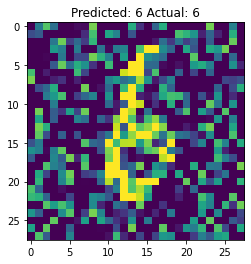

Confidence: 0.26464987


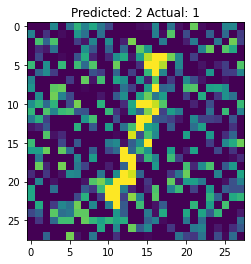

Confidence: 0.6770737


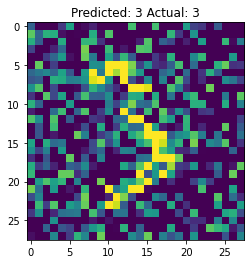

Confidence: 0.8980687


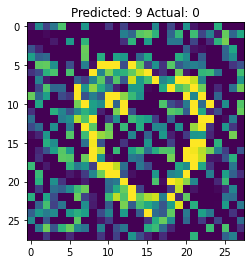

Confidence: 0.9484323


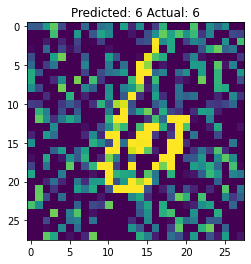

Confidence: 0.37814167


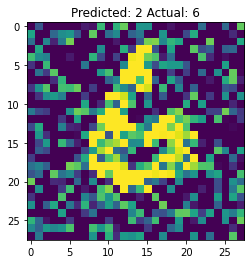

In [124]:
# first, let's add noise to 1 image and see where it moves in t-SNE space

from scipy.special import softmax
noise=0.8      ### change to noise = 0 (clear) >>0.8 (noise)
predictions2=[]
for i in range(len(ds_test)-1):#len(ds_test)):
    dat=[np.clip(im[:,:,0]+np.random.uniform(-noise,noise,size=im[:,:,0].shape),0,1) for im in np.array(list(ds_test)[i][0])]#

    im=dat[-1]
    dat=np.array(dat).reshape(32,28,28,1)
    transposed=tf.convert_to_tensor(dat)
    predictions2+=[np.argmax(pred) for pred in (model.predict([transposed]))]
    confidence = np.max(softmax(model.predict([transposed])[-1]))
    #if float(gt_labels[len(predictions2)-1]) != predictions2[-1]:
    #    if confidence > 0.1:
    print('Confidence: '+str(confidence))
    plt.imshow(im)
    plt.title('Predicted: '+str(predictions2[-1])+' Actual: '+str(int(float(gt_labels[len(predictions2)-1]))))
    plt.show()
#softmax(model.predict([list(ds_test)[0][0]])).shape






In [125]:
batch_size=32
gt_labels=np.array(list(ds_test_label)[:(len(ds_test)-1)*batch_size]).reshape(len(ds_test)-1,batch_size).astype(float)

noise=0.8
results={'noise':[],'gt':[],'pred':[],'correct':[],'confidence':[]}
for noise in np.arange(0.0,2,0.1):
    print(noise)
    for i in range(len(ds_test)-1):#len(ds_test)-1):
        if i % 50 == 0:
            print(round(i/len(ds_test)*100,2))
        dat=[np.clip(im[:,:,0]+np.random.uniform(-noise,noise,size=im[:,:,0].shape),0,1) for im in np.array(list(ds_test)[i][0])]
        dat=np.array(dat).reshape(32,28,28,1)
        tensored=tf.convert_to_tensor(dat)
        #predictions2+=[np.argmax(pred) for pred in (model.predict([transposed]))]
        pred = np.argmax(model.predict([tensored]),axis=1)
        confidence = [np.max(softmax(v)) for v in model.predict([tensored])]
        gt = gt_labels[i]#[float(nn) for nn in gt_labels[i-1]]
        correct = (pred==gt).astype(int)
        results['noise']+=[noise]*batch_size
        results['gt']+=list(gt)
        results['pred']+=list(pred)
        results['correct']+=list(correct)
        #plt.imshow(dat[-1].reshape(28,28))
        #plt.show()
        #break
        results['confidence']+=list(confidence)
        #if float(gt = ) != predictions2[-1]:
        #    if confidence > 0.1:
        #print('Confidence: '+str(confidence))
        #plt.imshow(im)
        #plt.title('Predicted: '+str(predictions2[-1])+' Actual: '+str(int(float(gt_labels[len(predictions2)-1]))))
        #plt.show()

0.0
0.0
15.97
31.95
47.92
63.9
79.87
95.85
0.1
0.0
15.97
31.95
47.92
63.9
79.87
95.85
0.2
0.0
15.97
31.95
47.92
63.9
79.87
95.85
0.30000000000000004
0.0
15.97
31.95
47.92
63.9
79.87
95.85
0.4
0.0
15.97
31.95
47.92
63.9
79.87
95.85
0.5
0.0
15.97
31.95
47.92
63.9
79.87
95.85
0.6000000000000001
0.0
15.97
31.95
47.92
63.9
79.87
95.85
0.7000000000000001
0.0
15.97
31.95
47.92
63.9
79.87
95.85
0.8
0.0
15.97
31.95
47.92
63.9
79.87
95.85
0.9
0.0
15.97
31.95
47.92
63.9
79.87
95.85
1.0
0.0
15.97
31.95
47.92
63.9
79.87
95.85
1.1
0.0
15.97
31.95
47.92
63.9
79.87
95.85
1.2000000000000002
0.0
15.97
31.95
47.92
63.9
79.87
95.85
1.3
0.0
15.97
31.95
47.92
63.9
79.87
95.85
1.4000000000000001
0.0
15.97
31.95
47.92
63.9
79.87
95.85
1.5
0.0
15.97
31.95
47.92
63.9
79.87
95.85
1.6
0.0
15.97
31.95
47.92
63.9
79.87
95.85
1.7000000000000002
0.0
15.97
31.95
47.92
63.9
79.87
95.85
1.8
0.0
15.97
31.95
47.92
63.9
79.87
95.85
1.9000000000000001
0.0
15.97
31.95
47.92
63.9
79.87
95.85


## Data is actually very robust to random noise!

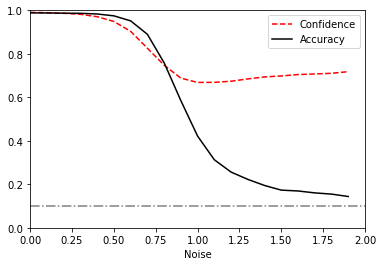

In [126]:
results = pd.DataFrame(results)
all_correct=[]
all_confidence=[]
for noise in np.arange(0,2,0.1):
    noise_results = results.loc[results['noise']==noise,]
    if len(noise_results)==0: continue
    noise_correct = np.mean(noise_results['correct'].values)
    noise_conf = np.mean(noise_results['confidence'].values)
    all_correct.append([noise,noise_correct])
    all_confidence.append([noise,noise_conf])
all_correct=np.array(all_correct)
all_confidence=np.array(all_confidence)
plt.plot(all_confidence[:,0],all_confidence[:,1],'r--',label='Confidence')
plt.plot(all_correct[:,0],all_correct[:,1],'k-',label='Accuracy')
plt.plot([0,2],[0.1,0.1],color='gray',linestyle='-.')
plt.legend()
plt.ylim([0,1])
plt.xlim([0,2])
plt.xlabel('Noise')
#plt.ylabel('Accuracy')
plt.show()
        
        
        
        
#As noise increase, the accuracy significantly decreases but confidence is somewhat not optimal (navie) 
#confidence 不应该这么高(noise=2, confidence=0.6) >>> high confidence with low accuracy (doesn't make sense)
        

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


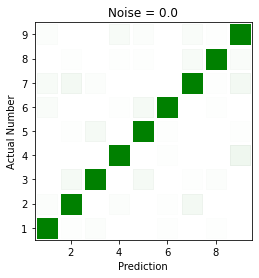

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


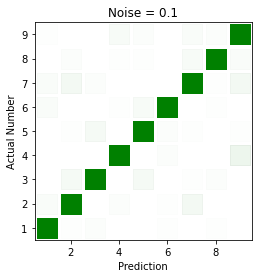

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


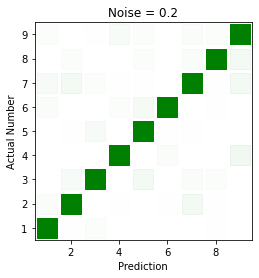

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


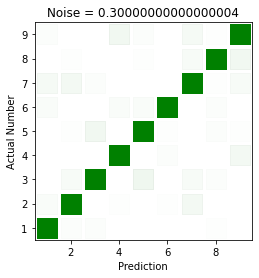

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


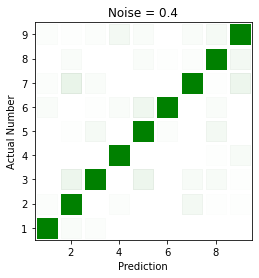

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


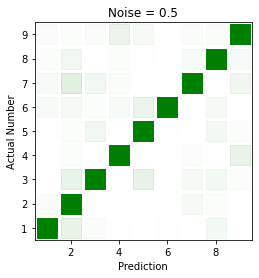

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


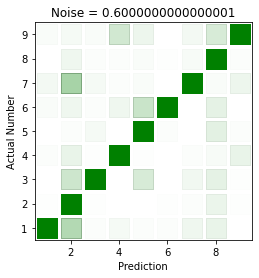

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


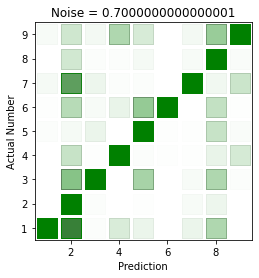

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


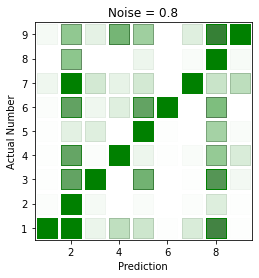

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


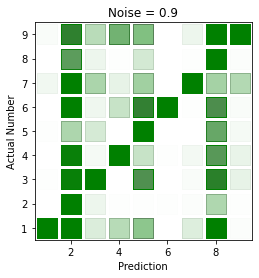

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


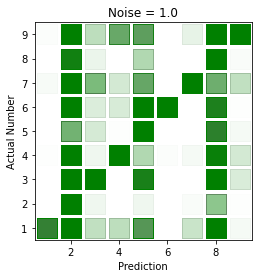

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


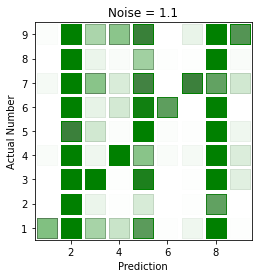

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


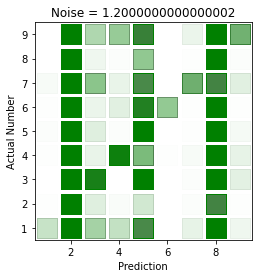

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


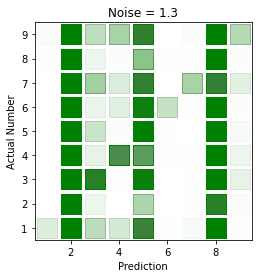

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


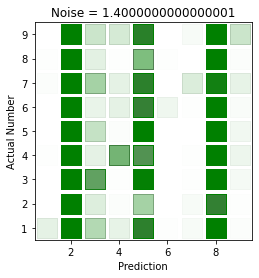

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


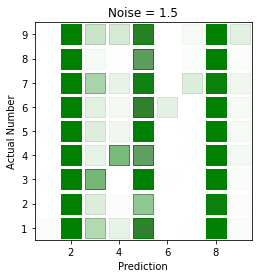

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


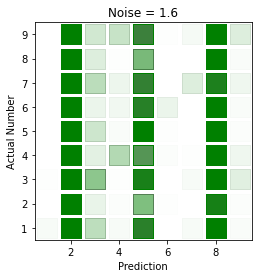

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


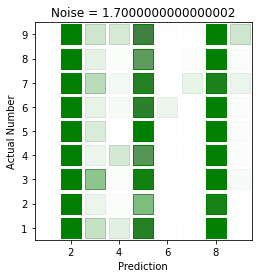

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


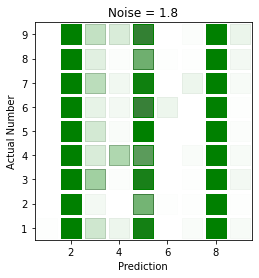

<ipython-input-127-da1038717d59>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(1)


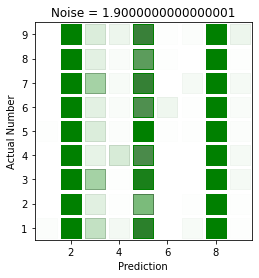

In [127]:

for ii,noise in enumerate(np.arange(0,2,0.1)):
    noise_results = results.loc[results['noise']==noise,]
    if len(noise_results)==0: continue
    plt.plot(noise_results['pred'],noise_results['gt'],'sg',ms=20,alpha=0.008)
    plt.ylim([0.5,9.5])
    plt.xlim([0.5,9.5])
    plt.xlabel('Prediction')
    plt.ylabel('Actual Number')
    plt.title('Noise = '+str(noise))
    plt.axes().set_aspect(1)
    plt.show()
    

## Can we stear predictions to a particular number?

### The goal is to be sneaky: we want to make adversarial examples that are not obviously wrong, easy to add perhaps in the wild

19


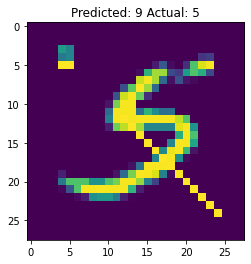

34


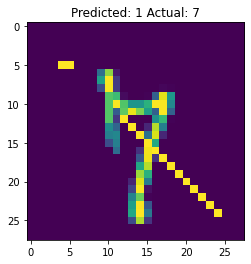

41


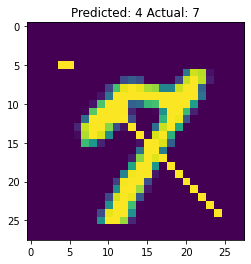

49


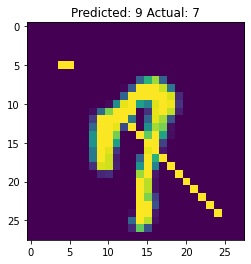

54


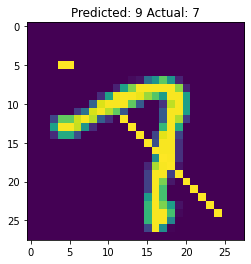

57


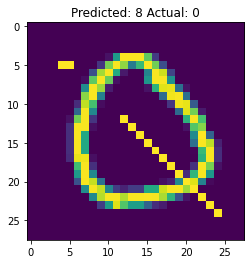

63


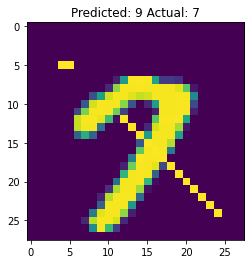

64


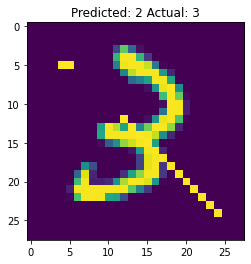

89


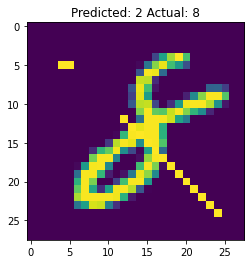

92


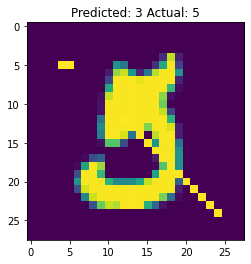

97


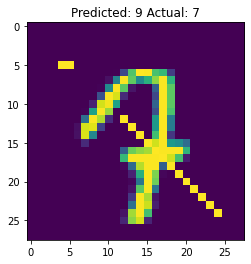

110


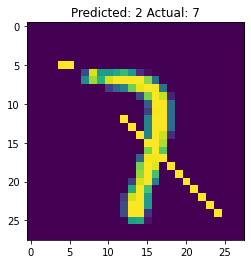

117


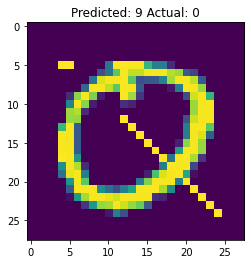

137


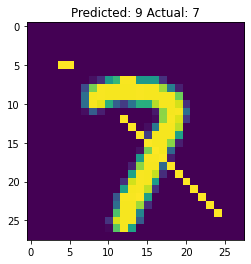

138


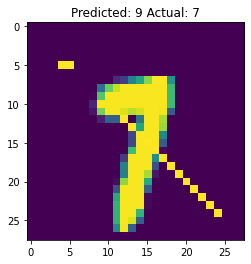

139


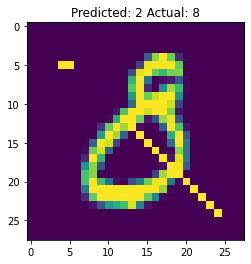

159


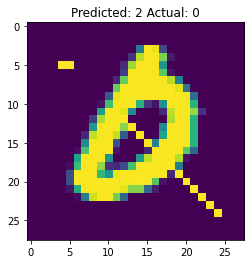

161


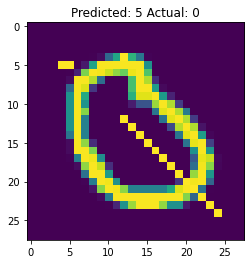

163


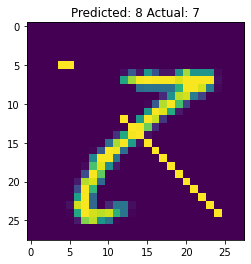

168


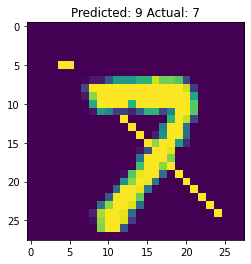

204


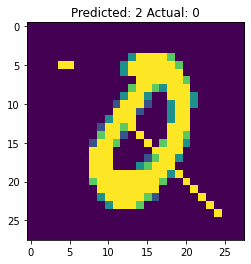

209


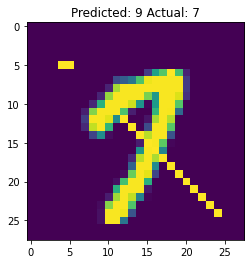

212


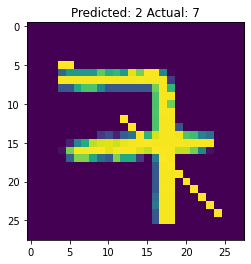

214


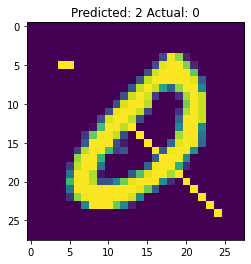

222


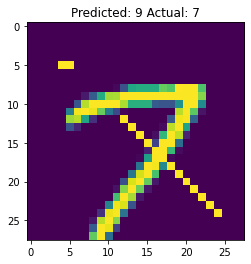

224


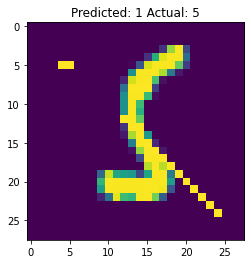

229


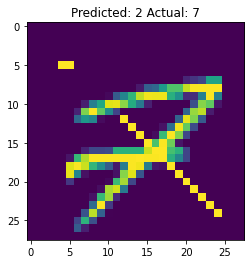

231


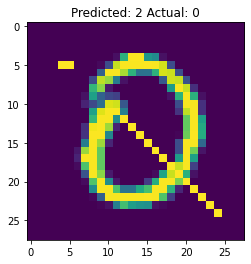

240


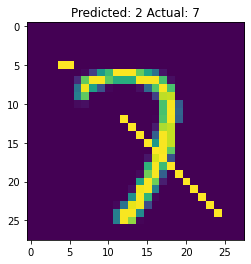

243


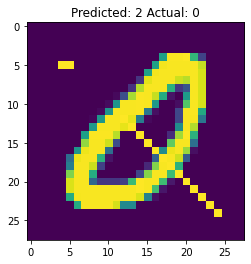

253


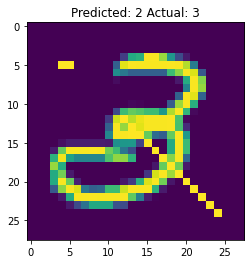

262


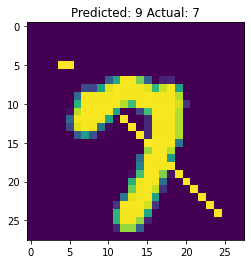

279


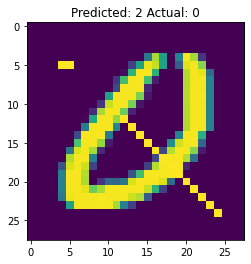

287


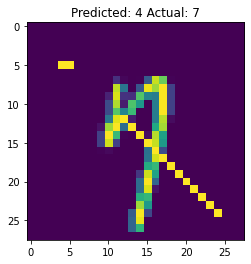

309


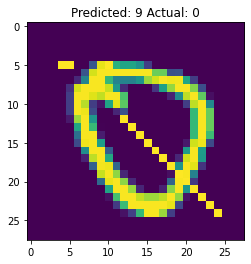

0.8967347756410257
0
Predicted: 3 Actual: 3
1
Predicted: 4 Actual: 4
2
Predicted: 4 Actual: 4
3
Predicted: 3 Actual: 3
4
Predicted: 8 Actual: 8
5
Predicted: 9 Actual: 9
6
Predicted: 6 Actual: 6
7
Predicted: 6 Actual: 6
8
Predicted: 1 Actual: 1
9
Predicted: 4 Actual: 4
10
Predicted: 5 Actual: 5
11
Predicted: 2 Actual: 2
12
Predicted: 6 Actual: 6
13
Predicted: 8 Actual: 8
14
Predicted: 9 Actual: 9
15
Predicted: 6 Actual: 6
16
Predicted: 6 Actual: 6
17
Predicted: 2 Actual: 2
18
Predicted: 7 Actual: 7
19
Predicted: 9 Actual: 5
20
Predicted: 7 Actual: 7
21
Predicted: 5 Actual: 5
22
Predicted: 9 Actual: 9
23
Predicted: 1 Actual: 1
24
Predicted: 4 Actual: 4
25
Predicted: 2 Actual: 2
26
Predicted: 6 Actual: 6
27
Predicted: 5 Actual: 5
28
Predicted: 1 Actual: 1
29
Predicted: 3 Actual: 3
30
Predicted: 1 Actual: 1
31
Predicted: 2 Actual: 2
32
Predicted: 2 Actual: 2
33
Predicted: 9 Actual: 9
34
Predicted: 1 Actual: 7
35
Predicted: 5 Actual: 5
36
Predicted: 3 Actual: 3
37
Predicted: 8 Actual: 8
38


308
Predicted: 3 Actual: 3
309
Predicted: 9 Actual: 0
310
Predicted: 6 Actual: 6
311
Predicted: 6 Actual: 6
0
[[3, 3], [4, 4], [4, 4], [3, 3], [8, 8], [9, 9], [6, 6], [6, 6], [1, 1], [4, 4], [5, 5], [2, 2], [6, 6], [8, 8], [9, 9], [6, 6], [6, 6], [2, 2], [7, 7], [9, 5], [7, 7], [5, 5], [9, 9], [1, 1], [4, 4], [2, 2], [6, 6], [5, 5], [1, 1], [3, 3], [1, 1], [2, 2], [2, 2], [9, 9], [1, 7], [5, 5], [3, 3], [8, 8], [0, 0], [1, 1], [5, 5], [4, 7], [8, 8], [5, 5], [9, 9], [0, 0], [5, 5], [1, 1], [6, 6], [9, 7], [5, 5], [5, 5], [5, 5], [2, 2], [9, 7], [7, 7], [2, 2], [8, 0], [4, 4], [2, 2], [2, 2], [6, 6], [8, 8], [9, 7], [2, 3], [8, 8], [5, 5], [3, 3], [2, 2], [3, 3], [4, 4], [5, 5], [2, 2], [1, 1], [1, 1], [1, 1], [4, 4], [7, 7], [3, 3], [3, 3], [1, 1], [0, 0], [6, 6], [3, 3], [4, 4], [7, 7], [1, 1], [4, 4], [6, 6], [2, 8], [2, 2], [4, 4], [3, 5], [3, 3], [3, 3], [3, 3], [1, 1], [9, 7], [3, 3], [9, 9], [9, 9], [3, 3], [3, 3], [1, 1], [2, 2], [8, 8], [6, 6], [4, 4], [6, 6], [9, 9], [2, 7], [

In [131]:
im = np.array(list(ds_test)[0][0])
attack = np.zeros(shape=(28,28))
for ii in range(12,25):
    attack[ii,ii]=1
attack[5:6,4:6]= 1
attack_results= {'noise':[],'gt':[],'pred':[],'correct':[],'confidence':[]}
for i in range(len(ds_test)-1):#len(ds_test)-1):
    dat=[np.clip(im[:,:,0]+attack,0,1) for im in np.array(list(ds_test)[i][0])]
    dat=np.array(dat).reshape(32,28,28,1)
    tensored=tf.convert_to_tensor(dat)
    #predictions2+=[np.argmax(pred) for pred in (model.predict([transposed]))]
    pred = np.argmax(model.predict([tensored]),axis=1)
    confidence = [np.max(softmax(v)) for v in model.predict([tensored])]
    gt = gt_labels[i]#[float(nn) for nn in gt_labels[i-1]]
    correct = (pred==gt).astype(int)
    attack_results['noise']+=[noise]*batch_size
    attack_results['gt']+=list(gt)
    attack_results['pred']+=list(pred)
    attack_results['correct']+=list(correct)
    attack_results['confidence']+=list(confidence)
    if pred[-1]!=int(gt[-1]):#i % 50 == 0:
        print(i)
        im = dat[-1].reshape(28,28)
        plt.imshow(im)
        plt.title('Predicted: '+str(pred[-1])+' Actual: '+str(int(gt[-1])))
        plt.show()
print(np.mean(attack_results['correct']))

dic = []
tf_boy = 0
for i in range(len(ds_test)-1):#len(ds_test)-1):
    dat=[np.clip(im[:,:,0]+attack,0,1) for im in np.array(list(ds_test)[i][0])]
    dat=np.array(dat).reshape(32,28,28,1)
    tensored=tf.convert_to_tensor(dat)
    #predictions2+=[np.argmax(pred) for pred in (model.predict([transposed]))]
    pred = np.argmax(model.predict([tensored]),axis=1)
    confidence = [np.max(softmax(v)) for v in model.predict([tensored])]
    gt = gt_labels[i]#[float(nn) for nn in gt_labels[i-1]]
    correct = (pred==gt).astype(int)
    attack_results['noise']+=[noise]*batch_size
    attack_results['gt']+=list(gt)
    attack_results['pred']+=list(pred)
    attack_results['correct']+=list(correct)
    attack_results['confidence']+=list(confidence)
    #if pred[-1]!=int(gt[-1]):#i % 50 == 0:
    print(i)
    print('Predicted: '+str(pred[-1])+' Actual: '+str(int(gt[-1])))
    dic.append([int(pred[-1]),int(gt[-1])])
    if int(pred[-1]) == 3 and int(pred[-1]) == 5:
        tf_boy += 1

print(tf_boy)        
print(dic)

In [138]:
ttt = 0
k=0
for i in dic:
    if i[0] == i[1]:
        ttt += 1
    k += 1
print('correct:', ttt)

print('total:', k)

print('Overall Accuracy:', ttt/k)

correct: 277
total: 312
Overall Accuracy: 0.8878205128205128


11


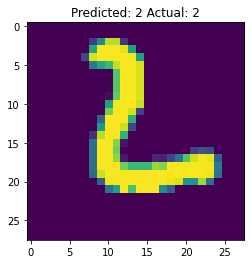

19


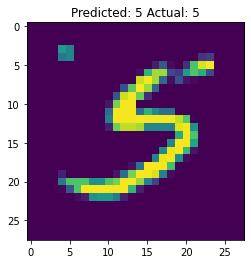

25


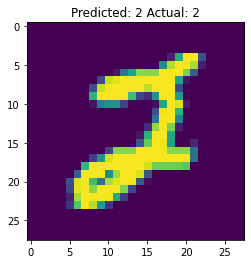

0.8967347756410257


In [130]:
im = np.array(list(ds_test)[0][0])
attack = np.zeros(shape=(28,28))
#for ii in range(12,25):
#    attack[ii,ii]=1
#attack[5:8,5:8]=1
#attack_results= {'noise':[],'gt':[],'pred':[],'correct':[],'confidence':[]}
for i in [11,19,25]:#len(ds_test)-1):
    dat=[np.clip(im[:,:,0]+attack,0,1) for im in np.array(list(ds_test)[i][0])]
    dat=np.array(dat).reshape(32,28,28,1)
    tensored=tf.convert_to_tensor(dat)
    #predictions2+=[np.argmax(pred) for pred in (model.predict([transposed]))]
    pred = np.argmax(model.predict([tensored]),axis=1)
    confidence = [np.max(softmax(v)) for v in model.predict([tensored])]
    gt = gt_labels[i]#[float(nn) for nn in gt_labels[i-1]]
    correct = (pred==gt).astype(int)
    #attack_results['noise']+=[noise]*batch_size
    #attack_results['gt']+=list(gt)
    #attack_results['pred']+=list(pred)
    #attack_results['correct']+=list(correct)
    #attack_results['confidence']+=list(confidence)
    #if pred[0]!=int(gt[0]):#i % 50 == 0:
    print(i)
    im = dat[-1].reshape(28,28)
    plt.imshow(im)
    plt.title('Predicted: '+str(pred[-1])+' Actual: '+str(int(gt[-1])))
    plt.show()
print(np.mean(attack_results['correct']))





### We can conclude that naive attacks can work well some of the time, can perform poorly all of the time, but can never work well all of the time. In contrast, more recent work has shown remarkable success through more nuanced attacks